# Introduction

https://www.nycfoodpolicy.org/restaurant-grading-system-hunter-college-nyc-food-policy-center/

Cities across the United States are capitalizing on big data. Predictive policing is becoming a prominent tool for public safety in many cities. In Boston, an algorithm helps determine “problem properties” where the city can target interventions. In Chicago, they are protecting citizens by predicting which landlords are not complying with city ordinances. In New York, the Fire Department sends inspectors to the highest risk buildings so they can prevent deadly fires from breaking out.

According to the CDC, more than 48 million Americans per year become sick from food, and an estimated 75% of the outbreaks came from food prepared by caterers, delis, and restaurants. In most cities, health inspections are generally random, which can increase time spent on spot checks at clean restaurants that have been following the rules closely — and missed opportunities to improve health and hygiene at places with more pressing food safety issues.

The goal for this project is to leverage public citizen generated data from social media to narrow the search for critical health and safety violations in New York City. As the City of New York manages  an open data portal, everyone can access historical hygiene inspections and violation records. By combine these two data source this project aims to determine which words, phrases, ratings, and patterns among restaurants lead to critical health and safety violations. This model can assist city health inspectors do their job better by prioritizing the kitchens most likely to be in violation of code.

The New York Health Department inspects the approximately 27,000 restaurants within the city to monitor their compliance with food safety regulations. Inspectors observe how food is prepared, served and stored and whether restaurant workers are practicing good hygiene. They check food temperatures, equipment maintenance and pest control measures.

### Imports

In [361]:
from IPython import display
from bs4 import BeautifulSoup as bs
import requests
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
import plotly.express as px

import warnings
import time

import folium
import folium.plugins as plugins

# misc
import glob, os
import ast

call_apis = False
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth',200)
pd.set_option('display.max_columns',50)
pd.options.display.float_format = '{:.2f}'.format

from sklearn.preprocessing import OneHotEncoder

#NLP 
import spacy
nlp = spacy.load("en_core_web_lg")
from spacy import displacy
import nltk 
import string
from nltk.collocations import *
from nltk import word_tokenize,wordpunct_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
#nltk.download('wordnet')

# sk-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.tree import DecisionTreeClassifier

### Can you predict if a restaurant has received a C Grade?
### Can you predict a restaurants yelp rating based on its review text?
### Can you recommend a similar restaurant nearby with a better health score for restaurants searched for with a C

# Obtain

For this project there will be two sources and types of data used:

* Historical health and hygiene inspections recorded by New York City Department of Health and Mental Hygiene (DOHMH) public health inspectors
* User generated Yelp business ratings and reviews

This project requires data pulled from two different sources, the City of New York and Yelp. To obtain the data we will call the API keys.

 > The dataset contains every sustained or not yet adjudicated violation citation from every full or special program inspection conducted up to three years prior to the most recent inspection for restaurants and college cafeterias in an active status on the RECORD DATE (date of the data pull). When an inspection results in more than one violation, values for associated fields are repeated for each additional violation record. Establishments are uniquely identified by their CAMIS (record ID) number. Keep in mind that thousands of restaurants start business and go out of business every year; only restaurants in an active status are included in the dataset.
Records are also included for each restaurant that has applied for a permit but has not yet been inspected and for inspections resulting in no violations. Establishments with inspection date of 1/1/1900 are new establishments that have not yet received an inspection. Restaurants that received no violations are represented by a single row and coded as having no violations using the ACTION field.
Because this dataset is compiled from several large administrative data systems, it contains some illogical values that could be a result of data entry or transfer errors. Data may also be missing.
This dataset and the information on the Health Department’s Restaurant Grading website come from the same data source. The Health Department’s Restaurant Grading website is here:
http://www1.nyc.gov/site/doh/services/restaurant-grades.page

> Why does the Health Department inspect restaurants?
The Health Department inspects the approximately 27,000 restaurants in New York City to monitor their compliance with food safety regulations. Inspectors observe how food is prepared, served and stored and whether restaurant workers are practicing good hygiene. They check food temperatures, equipment maintenance and pest control measures.

> Since 2010, New York City has required restaurants to post letter grades that correspond to scores received from sanitary inspections. An inspection score of 0 to 13 is an A, 14 to 27 points is a B, and 28 or more points is a C. Grade cards must be posted where they can easily be seen by people passing by.

> The New York City Health Department inspects all food service establishments to make sure they meet Health Code requirements, which helps prevent
foodborne illness. How often a restaurant is inspected depends on its inspection score. Restaurants that receive a low score on the initial or first inspection
in the inspection cycle are inspected less often than those that receive a high score.

> The points for a particular violation depend on the health risk it poses to the public. Violations fall into three categories:
>* A public health hazard, such as failing to keep food at the right temperature, triggers a minimum of 7 points. If the violation can’t be corrected before the inspection ends, the Health Department may close the restaurant until it’s fixed.
>* A critical violation, for example, serving raw food such as a salad without properly washing it first, carries a minimum of 5 points.
>* A general violation, such as not properly sanitizing
cooking utensils, receives at least 2 points.

>Inspectors assign additional points to reflect the extent of the
violation. A violation’s condition level can range from 1 (least
extensive) to 5 (most extensive). For example, the presence of
one contaminated food item is a condition level 1 violation,
generating 7 points. Four or more contaminated food items
is a condition level 4 violation, resulting in 10 points. 

> How are restaurants graded?
Violations found during inspections carry point values, and a restaurant’s score corresponds to a letter grade. The point/grade cut-offs are the same as for mobile food vending letter grading, with fewer points corresponding to a better grade:

>* "A" grade: 0 to 13 points for sanitary violations
>* "B" grade: 14 to 27 points for sanitary violations
>* "C" grade: 28 or more points for sanitary violations


The City of New York inspects all restaurants cyclically. And if a business does not pass it's initial inspection for the cycle, it will be re-inspected in 3-5 months.

## Obtaining Restaurant Inspection Results from NYC Open Data Portal

The dataset can be obtained here

https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j

The dataset was downloaded and saved to this repository. Let's load it in and explore its contents.

Detailed descriptions about each column can be found in the Restaurant Inspection Data Dictionary.

In [17]:
doh_df = pd.read_csv('data/nyc_open_data/DOHMH_New_York_City_Restaurant_Inspection_Results.csv')
doh_df

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,50008319,POULETTE,Manhattan,790,9 AVENUE,10019.00,2129569488,Chicken,01/28/2019,Violations were cited in the following area(s).,04D,"Food worker does not wash hands thoroughly after using the toilet, coughing, sneezing, smoking, eating, preparing raw foods or otherwise contaminating hands.",Critical,22,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.77,-73.99,104.00,3.00,13300.00,1025235.00,1010430004.00,MN15
1,41678734,TINY'S DINER,Bronx,3603,RIVERDALE AVENUE,10463.00,7187087600,American,09/23/2019,Violations were cited in the following area(s).,04M,Live roaches present in facility's food and/or non-food areas.,Critical,24,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.89,-73.91,208.00,11.00,29500.00,2084186.00,2057960167.00,BX29
2,40795021,TAO RESTAURANT,Manhattan,42,EAST 58 STREET,10022.00,2128882288,Asian/Asian Fusion,03/11/2020,Violations were cited in the following area(s).,10F,"Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed, raised, spaced or movable to al...",Not Critical,9,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.76,-73.97,105.00,4.00,11202.00,1036073.00,1012930047.00,MN17
3,40795021,TAO RESTAURANT,Manhattan,42,EAST 58 STREET,10022.00,2128882288,Asian/Asian Fusion,03/11/2020,Violations were cited in the following area(s).,10F,"Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed, raised, spaced or movable to al...",Not Critical,9,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.76,-73.97,105.00,4.00,11202.00,1036073.00,1012930047.00,MN17
4,40538234,"DUNKIN',' BASKIN ROBBINS",Queens,9925,HORACE HARDING EXPRESSWAY,11368.00,7182719222,Donuts,07/29/2021,Violations were cited in the following area(s).,06E,"Sanitized equipment or utensil, including in-use food dispensing utensil, improperly used or stored.",Critical,10,A,07/29/2021,03/24/2022,Cycle Inspection / Initial Inspection,40.74,-73.86,404.00,21.00,43702.00,4047915.00,4019480019.00,QN25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186222,41556790,FIVE GUYS FAMOUS BURGERS AND FRIES,Manhattan,2847,BROADFWAY,NaN,2126787701,Hamburgers,03/01/2019,Violations were cited in the following area(s).,10F,"Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed, raised, spaced or movable to al...",Not Critical,3,A,03/01/2019,03/24/2022,Cycle Inspection / Initial Inspection,0.00,0.00,NaN,NaN,NaN,NaN,1.00,NaN
186223,50032876,TANNER SMITH'S,Manhattan,204,WEST 55 STREET,10019.00,9175172283,American,06/07/2019,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.,Not Critical,12,A,06/07/2019,03/24/2022,Cycle Inspection / Initial Inspection,40.76,-73.98,105.00,4.00,13700.00,1024857.00,1010260037.00,MN17
186224,50003842,T- 45,Manhattan,135,WEST 45 STREET,10036.00,6466403775,American,07/26/2018,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained; anti-siphonage or backflow prevention device not provided where required; equipment or floor not properly drained; sewage disposal system in disrepai...,Not Critical,49,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.76,-73.98,105.00,4.00,11900.00,1089796.00,1009980015.00,MN17
186225,41640824,RICURAS ECUADORIAN BAKERY,Bronx,1576,WATSON AVENUE,10472.00,

The dataset contains 186,227 inspection results. However, when an inspection results in more than one violation, values for associated fields are repeated for each additional violation record. So let's check how many individual restaurants are in the dataset.

### Understanding NYC DOHMH Data

In [18]:
# How many unique restaurants are in this dataset?
n_unique = doh_df['CAMIS'].nunique()
print(f'There are {n_unique} unique restaurants in the dataset. ')

There are 19792 unique restaurants in the dataset. 


In [19]:
# Get more information about the dataset contents
doh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186227 entries, 0 to 186226
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  186227 non-null  int64  
 1   DBA                    186200 non-null  object 
 2   BORO                   186227 non-null  object 
 3   BUILDING               185799 non-null  object 
 4   STREET                 186227 non-null  object 
 5   ZIPCODE                183146 non-null  float64
 6   PHONE                  186214 non-null  object 
 7   CUISINE DESCRIPTION    186226 non-null  object 
 8   INSPECTION DATE        186227 non-null  object 
 9   ACTION                 186227 non-null  object 
 10  VIOLATION CODE         185413 non-null  object 
 11  VIOLATION DESCRIPTION  185863 non-null  object 
 12  CRITICAL FLAG          186227 non-null  object 
 13  SCORE                  186227 non-null  int64  
 14  GRADE                  67933 non-nul

In [20]:
doh_df['ZIPCODE'].astype(str)

0         10019.0
1         10463.0
2         10022.0
3         10022.0
4         11368.0
           ...   
186222        nan
186223    10019.0
186224    10036.0
186225    10472.0
186226    10461.0
Name: ZIPCODE, Length: 186227, dtype: object

In [21]:
doh_df['Community Board'].astype(str)

0         104.0
1         208.0
2         105.0
3         105.0
4         404.0
          ...  
186222      nan
186223    105.0
186224    105.0
186225    209.0
186226    210.0
Name: Community Board, Length: 186227, dtype: object

In [22]:
doh_df['Council District'].astype(str)

0          3.0
1         11.0
2          4.0
3          4.0
4         21.0
          ... 
186222     nan
186223     4.0
186224     4.0
186225    18.0
186226    13.0
Name: Council District, Length: 186227, dtype: object

In [23]:
doh_df['Census Tract'].astype(str)

0         13300.0
1         29500.0
2         11202.0
3         11202.0
4         43702.0
           ...   
186222        nan
186223    13700.0
186224    11900.0
186225     5001.0
186226    30000.0
Name: Census Tract, Length: 186227, dtype: object

Every row has a restaurant ID, address, date, and score. Let's ensure there aren't any duplicated rows.

In [24]:
print(f'There are {doh_df.duplicated(keep=False).sum()} duplicated rows. ')

There are 22010 duplicated rows. 


In [25]:
# Let's drop these duplucated rows
doh_df.drop_duplicates(keep='first',inplace=True)

In [26]:
# Confirming duplicates have been removed
doh_df.shape

(174725, 26)

Since this project will be leveraging data publicly generated from social media a lookup value will be needed to call the API and join the tables. The Yelp API has an endpoint for Phone Search. This will allow us to pull Yelp business data for each restaurant by proivinging a telephone number. More infomration can be found in the [documentation here.](https://www.yelp.com/developers/documentation/v3/business_search_phone)

In [27]:
# Checking that every restaunt has a phone number
missing_num = doh_df['PHONE'].isna().sum()
print(f'There are {missing_num} restaunts missing a telephone number.')

There are 13 restaunts missing a telephone number.


In [28]:
# Since only 13 numbers are missing, these rows can be dropped
doh_df.dropna(subset=['PHONE'],inplace=True)

In [29]:
# Confirming records were dropped
doh_df['PHONE'].isna().sum()

0

In [30]:
# How many unique restaurants are remaining?
n_unique = doh_df['CAMIS'].nunique()
print(f'There are {n_unique} unique restaurants remaining in the dataset. ')

There are 19790 unique restaurants remaining in the dataset. 


Let's explore the date range for this dataset.

In [31]:
doh_df['INSPECTION DATE'] =  pd.to_datetime(doh_df['INSPECTION DATE'])
begin_date = doh_df['INSPECTION DATE'].min()
end_date = doh_df['INSPECTION DATE'].max()
print(f'The data ranges from {begin_date} to {end_date}')

The data ranges from 2009-05-16 00:00:00 to 2022-03-23 00:00:00


Inspections in this dataset range from May 2009 up to March 2022.

### Target Variable -- NYCDOH Inspection Grades

Health code violations found during an inspections carries a point value, and a restaurant’s score corresponds to a letter grade. A lower point score, leads to a better letter grade:

* "A" grade: 0 to 13 points for sanitary violations
* "B" grade: 14 to 27 points for sanitary violations
* "C" grade: 28 or more points for sanitary violations

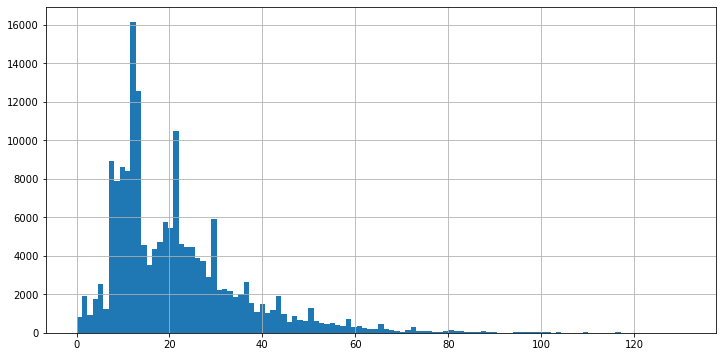

In [32]:
# Let see what the score distribution is
doh_df['SCORE'].hist(bins=113, figsize=(12,6));

In [33]:
doh_df['SCORE'].describe()

count   174712.00
mean        21.36
std         14.36
min          0.00
25%         12.00
50%         18.00
75%         27.00
max        131.00
Name: SCORE, dtype: float64

In [34]:
doh_graded = doh_df.copy()

In [35]:
doh_graded.drop(columns=['INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG','GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE'],inplace=True)

In [36]:
doh_graded['A'] = (doh_graded['SCORE'] < 14).astype(int)
doh_graded['B'] = (doh_graded['SCORE'] > 13).astype(int) & (doh_df['SCORE'] < 28).astype(int)
doh_graded['C'] = (doh_graded['SCORE'] > 27).astype(int)

In [37]:
doh_grouped = doh_graded.groupby(by=['CAMIS', 'DBA','CUISINE DESCRIPTION',
                                     'BORO', 'BUILDING',
                                     'STREET', 'ZIPCODE', 'PHONE', 'Latitude',
                                     'Longitude', 'Community Board',
                                     'Council District','Census Tract'],dropna=False)['A','B','C'].sum()

In [38]:
(doh_grouped['B'] > 0).sum()

9977

Of the 19,790 unique restaurants, 9,977 failed an initial cycle inspection at least once.

In [39]:
(doh_grouped['C'] > 0).sum()

5648

Of the 19,790 unique restaurants, 5,648 severly failed an initial cycle inspection at least once and are at risk of being closed by the DOHMH.

In [40]:
# Creating the Target Variable 'Severe' for Restaurants that have scored over 28 points in an initial inspection.
doh_grouped['Severe'] = (doh_grouped['C'] > 0).astype(int)

In [41]:
nyc_df = doh_grouped.reset_index()
nyc_df.drop(['A','B','C'],axis=1, inplace=True)
nyc_df

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe
0,30075445,MORRIS PARK BAKE SHOP,Bakery Products/Desserts,Bronx,1007,MORRIS PARK AVENUE,10462.00,7188924968,40.85,-73.86,211.00,13.00,25200.00,0
1,30112340,WENDY'S,Hamburgers,Brooklyn,469,FLATBUSH AVENUE,11225.00,7182875005,40.66,-73.96,309.00,40.00,32700.00,0
2,30191841,DJ REYNOLDS PUB AND RESTAURANT,Irish,Manhattan,351,WEST 57 STREET,10019.00,2122452912,40.77,-73.98,104.00,3.00,13900.00,0
3,40356018,RIVIERA CATERERS,American,Brooklyn,2780,STILLWELL AVENUE,11224.00,7183723031,40.58,-73.98,313.00,47.00,34800.00,0
4,40356483,WILKEN'S FINE FOOD,Sandwiches,Brooklyn,7114,AVENUE U,11234.00,7184443838,40.62,-73.91,318.00,46.00,70000.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19785,50115169,Sobak,Korean,Manhattan,51,CANAL STREET,10002.00,9294018597,40.71,-73.99,103.00,1.00,1600.00,0
19786,50116155,SEPTEMBER,Coffee/Tea,Brooklyn,83,SARATOGA AVENUE,11233.00,5086491703,40.68,-73.92,316.00,41.00,37300.00,0
19787,50117350,SONG TEA,Coffee/Tea,Manhattan,488,7 AVENUE,10018.00,6466697802,40.75,-73.99,105.00,3.00,10900.00,0
19788,50117434,LA POLLERA COLORADA,Spanish,Queens,8213,NORTHERN BLVD,11372.00,7184246531,40.76,-73.89,403.00,25.00,32700.00,1


#### NYC DOH Data Exploration

In [42]:
nyc_df['BORO'].value_counts()

Manhattan        7892
Brooklyn         4801
Queens           4468
Bronx            1920
Staten Island     704
0                   5
Name: BORO, dtype: int64

In [43]:
nyc_df['CUISINE DESCRIPTION'].value_counts()

American             4269
Chinese              1716
Coffee/Tea           1316
Pizza                1249
Italian               829
                     ... 
Iranian                 3
Fruits/Vegetables       2
Fusion                  1
Chilean                 1
Basque                  1
Name: CUISINE DESCRIPTION, Length: 84, dtype: int64

In [44]:
nyc_df['ZIPCODE'].value_counts()

10019.00    513
10036.00    469
10003.00    463
10001.00    367
10022.00    359
           ... 
10115.00      1
10173.00      1
10285.00      1
10177.00      1
10069.00      1
Name: ZIPCODE, Length: 221, dtype: int64

## Obtaining Yelp Buniness and Review Data

Now that we have an understanding of the city's inspection results and have explored that dataset it is time to pull in data from the crowd-sourced review platform Yelp.

In [45]:
# Loading in locally stored API credentials. 
# You can sign up for access and obtain credentials to the Yelp API here: 
# https://www.yelp.com/developers/documentation/v3

with open('/Users/Rob/.secret/yelp_api.json') as f:
    creds = json.load(f)

In [46]:
# Checking creds were properly loaded in
creds.keys()

dict_keys(['api_key'])

### Yelp Business Search

In [93]:
# Formatting phone numbers provided in the NYCDOH dataset 
nyc_df['PHONE'] = '+1'+nyc_df['PHONE']

# Ensure the list contains unique phone numbers only
phone_numbers = set(nyc_df['PHONE'])
phone_numbers = list(phone_numbers)
number_count = len(phone_numbers)
print(f'There are {number_count} unique phone numbers.')

There are 18937 unique phone numbers.


So we will call the Yelp API at the Phone Search Endpoint for all the numbers in the `phone_numbers` list. However the API only allows 5000 callers per day so we'll slice the list into smaller list.

In [48]:
# Slicing the phone list into smaller list to fit under the API daily limit restrictions
# phone_numbers1 = phone_numbers[1:1000]
# phone_numbers2 = phone_numbers[1000:2000]
# phone_numbers3 = phone_numbers[2000:2500]
# phone_numbers4 = phone_numbers[2500:3500]
# phone_numbers5 = phone_numbers[3500:5000]
# phone_numbers6 = phone_numbers[5000:6000]
# phone_numbers7 = phone_numbers[6000:7500]
# phone_numbers8 = phone_numbers[7500:10000]
# phone_numbers9 = phone_numbers[10000:12500]
# phone_numbers11 = phone_numbers[15000:17500]
# phone_numbers12 = phone_numbers[17500:20000]
# phone_numbers9 = phone_numbers[10000:12500]
# phone_numbers10 = phone_numbers[12500:15000]
# phone_numbers11 = phone_numbers[15000:17500]
# phone_numbers12 = phone_numbers[17500:19000]

In [49]:
# #Functionizing the Yelp API Phone Search

# def get_businesses(phone_numbers):
#     """Input a list of formatted phone numbers
#     (must start with + and include the country code, like +14159083801)
#     and returns a corresponding list of Yelp Businesses"""
    
#     biz_list = []
    
#     for number in phone_numbers:
#         url = 'https://api.yelp.com/v3/businesses/search/phone'
#         headers = {'Authorization': 'Bearer ' + creds['api_key']}
#         url_params = {'phone': number}
#         response = requests.get(url, headers=headers, params=url_params)
#         response_json = response.json()
#         biz_list.extend(response_json.get('businesses','U'))
        
#     while 'U' in biz_list:
#         biz_list.remove('U')
        
#     return biz_list

In [50]:
# # Call `get_business` function
# if call_apis == True:
#     biz_list12 = get_businesses(phone_numbers12)
    
#     # Save returned list as a DataFrame and .csv file
#     biz12_df = pd.DataFrame(biz_list12)
#     biz12_df.to_csv('data/yelp_data/yelp_business/yelp_phone12.csv',index=False)

In [51]:
# List of files containing Yelp business data
fpath = 'data/yelp_data/yelp_businesses/'
os.listdir(fpath)
query = fpath+"*.csv"
f_list = glob.glob(query)

In [52]:
# Append saved Yelp Business tables to a dict
yelp_tables = {}

for f in f_list:
    temp_df = pd.read_csv(f)
    fname = f.replace('data/yelp_data/yelp_businesses/yelp_phone','df_').replace('.csv','')
    yelp_tables[fname] = temp_df

In [53]:
yelp_df_list = [t for t in list(yelp_tables.keys())]

In [54]:
# Concatenating all Yelp Businesses responses from the Phone Search
yelp_businesses_df = pd.concat(yelp_tables,ignore_index=True)
yelp_businesses_df

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone
0,RzKR9QcYP03EQ_8DxTxowg,barrio-chino-new-york,Barrio Chino,https://s3-media0.fl.yelpcdn.com/bphoto/dpaRqPZD6xqDZo2ZfOyjnQ/o.jpg,False,https://www.yelp.com/biz/barrio-chino-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,1148,"[{'alias': 'mexican', 'title': 'Mexican'}, {'alias': 'bars', 'title': 'Bars'}]",4.00,"{'latitude': 40.718022, 'longitude': -73.990026}","['delivery', 'pickup']",$$,"{'address1': '253 Broome St', 'address2': None, 'address3': '', 'city': 'New York', 'zip_code': '10002', 'country': 'US', 'state': 'NY', 'display_address': ['253 Broome St', 'New York, NY 10002']}",12122286710,(212) 228-6710
1,hrP3xLWJ8sLwG_XxEGq61Q,reyes-restaurant-woodside,Reyes Restaurant,https://s3-media0.fl.yelpcdn.com/bphoto/_dwQGccROJaxa-oNIxQsEg/o.jpg,False,https://www.yelp.com/biz/reyes-restaurant-woodside?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,7,"[{'alias': 'latin', 'title': 'Latin American'}, {'alias': 'dominican', 'title': 'Dominican'}]",4.00,"{'latitude': 40.7466, 'longitude': -73.9098}",['delivery'],$,"{'address1': '4754 46th St', 'address2': '', 'address3': '', 'city': 'Woodside', 'zip_code': '11377', 'country': 'US', 'state': 'NY', 'display_address': ['4754 46th St', 'Woodside, NY 11377']}",17187529577,(718) 752-9577
2,in7QM4vNUTHVZIi7Outetg,mcdonalds-new-york-430,McDonald's,https://s3-media0.fl.yelpcdn.com/bphoto/bNmu8D1sjwJzbxxP9ZwJOQ/o.jpg,False,https://www.yelp.com/biz/mcdonalds-new-york-430?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,103,"[{'alias': 'burgers', 'title': 'Burgers'}, {'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'coffee', 'title': 'Coffee & Tea'}]",1.50,"{'latitude': 40.7163213865248, 'longitude': -74.0106988300204}",['delivery'],$,"{'address1': '167 Chambers St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10007', 'country': 'US', 'state': 'NY', 'display_address': ['167 Chambers St', 'New York, NY 10007']}",12126082405,(212) 608-2405
3,F-YGKegXRG2TE-Xw1AWeCA,popeyes-louisiana-kitchen-rockaway-beach-2,Popeyes Louisiana Kitchen,https://s3-media0.fl.yelpcdn.com/bphoto/A4MR2hDN3mWefMUT7bBB2A/o.jpg,False,https://www.yelp.com/biz/popeyes-louisiana-kitchen-rockaway-beach-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,21,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'seafood', 'title': 'Seafood'}, {'alias': 'chicken_wings', 'title': 'Chicken Wings'}]",2.00,"{'latitude': 40.587551867915515, 'longitude': -73.81088484629929}","['pickup', 'delivery']",$,"{'address1': '8601 Rockaway Beach Blvd', 'address2': '', 'address3': None, 'city': 'Rockaway Beach', 'zip_code': '11693', 'country': 'US', 'state': 'NY', 'display_address': ['8601 Rockaway Beach B...",17189452815,(718) 945-2815
4,rYl_R-UILYqA6vYsbNwLsg,joe-coffee-company-new-york-14,Joe Coffee Company,https://s3-media0.fl.yelpcdn.com/bphoto/e-nX3g-MQAN48MDPAv2cIg/o.jpg,False,https://www.yelp.com/biz/joe-coffee-company-new-york-14?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,24,"[{'alias': 'coffee', 'title': 'Coffee & Tea'}, {'alias': 'coffeeroasteries', 'title': 'Coffee Roasteries'}]",4.00,"{'latitude': 40.7126284147746, 'longitude': -74.0128198486877}",[],$$,"{'address1': '185 Greenwich St', 'address2': 'LL3110', 'address3': None, 'city': 'New York', 'zip_code': '10007', 'country': 'US', 'state': 'NY', 'display_address': ['185 Greenwich St', 'LL3110', ...",16467661719,(646) 766-1719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17297,K_e7_aNgghFLZ2zvjFSNkQ,lor

#### Exploring Yelp Businesses Response Data

In [55]:
yelp_businesses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17302 entries, 0 to 17301
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             17302 non-null  object 
 1   alias          17302 non-null  object 
 2   name           17302 non-null  object 
 3   image_url      16563 non-null  object 
 4   is_closed      17302 non-null  bool   
 5   url            17302 non-null  object 
 6   review_count   17302 non-null  int64  
 7   categories     17302 non-null  object 
 8   rating         17302 non-null  float64
 9   coordinates    17302 non-null  object 
 10  transactions   17302 non-null  object 
 11  price          14501 non-null  object 
 12  location       17302 non-null  object 
 13  phone          17302 non-null  int64  
 14  display_phone  17302 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(11)
memory usage: 1.9+ MB


In [56]:
yelp_businesses_df['price'].value_counts(normalize=True)

$$     0.53
$      0.37
$$$    0.07
$$$$   0.02
Name: price, dtype: float64

In [57]:
yelp_businesses_df['rating'].value_counts(normalize=True)

4.00   0.30
3.50   0.25
3.00   0.14
4.50   0.12
2.50   0.08
2.00   0.04
5.00   0.03
1.50   0.02
1.00   0.01
Name: rating, dtype: float64

In [58]:
yelp_businesses_df['categories'].value_counts(normalize=True)

[{'alias': 'chinese', 'title': 'Chinese'}]                                                                                                  0.05
[{'alias': 'pizza', 'title': 'Pizza'}]                                                                                                      0.04
[{'alias': 'coffee', 'title': 'Coffee & Tea'}]                                                                                              0.02
[{'alias': 'mexican', 'title': 'Mexican'}]                                                                                                  0.02
[{'alias': 'italian', 'title': 'Italian'}]                                                                                                  0.02
                                                                                                                                            ... 
[{'alias': 'bakeries', 'title': 'Bakeries'}, {'alias': 'gourmet', 'title': 'Specialty Food'}, {'alias': 'desserts', 'title': 'Dess

In [59]:
# Duplicates?
yelp_businesses_df[yelp_businesses_df.duplicated(['id'], keep=False)].count()

id               8474
alias            8474
name             8474
image_url        8123
is_closed        8474
url              8474
review_count     8474
categories       8474
rating           8474
coordinates      8474
transactions     8474
price            7109
location         8474
phone            8474
display_phone    8474
dtype: int64

In [60]:
yelp_businesses_df.describe()

,review_count,rating,phone
count,17302.00,17302.00,17302.00
mean,189.46,3.53,15227799712.25
std,378.43,0.79,2494930771.02
min,1.00,1.00,12062250663.00
25%,17.00,3.00,12127498940.50
50%,67.00,3.50,17182416042.00
75%,209.00,4.00,17186241444.00
max,13458.00,5.00,19732238527.00


In [61]:
yelp_businesses_df['review_count'].sum()

3278066

### Yelp Reviews

Now that all the restaurants from the NYC DOHMH dataset have been used to search the Yelp API and have been concatenated we can use the return url to gather reviews for each business.

In [62]:
# OLD from webscraping
# df_10_2 = df_10.loc[1000:2173]
# df_10_2.to_csv('df_10_2',index=False)

In [103]:
def get_text(url_list):
    """ Given a list of urls, this function will iterate through the list and 
    extract text from the first page of reviews. The data will be joined into 
    a corpus for each business"""
    
    review_txt = []

    for url in url_list:
        req = requests.get(url,allow_redirects=False)
        soup = bs(req.content)
        comments = soup.find_all(class_='raw__09f24__T4Ezm', lang="en")
        comment_txt = []

        for comment in comments:
            comment_txt.append(comment.text)

        comment_corp = ('.'.join(comment_txt))
        review_txt.append(comment_corp)
    return review_txt

Due to the time required to run this function, it can be broken into smaller requests. Since we already have smaller list used when we called the API earlier we can take the urls returned from the API here. 

In [64]:
# Obtaining list of yelp business urls from saved API response
url_list = list(yelp_tables['df_1']['url'])
len(url_list)

859

In [65]:
# Calling `get_text` function to obtain Yelp reviews
if call_apis == True:
    review_text = get_text(url_list)

In [66]:
# Saving the Reviews to a csv in the repository
if call_apis == True:
    rvw_txt = pd.DataFrame(review_text,columns=['Review_Text'])
    rvw_txt.to_csv('rvw_txt1.csv',index=False)


Repeat this for all the urls returned from the API

### Joining Yelp Reviews to Yelp Business Tables

In [67]:
# List of files containing Yelp business data
fpath = 'data/yelp_data/yelp_reviews/'
os.listdir(fpath)
query = fpath+"*.csv"
f_list = glob.glob(query)

In [68]:
# Append saved Yelp Reviews to a dict
rvw_tables = {}

for file in f_list:
    temp_df = pd.read_csv(file)
    fname = file.replace('data/yelp_data/yelp_reviews/rvw_txt','txt_').replace('.csv','')
    rvw_tables[fname] = temp_df

In [69]:
rvw_df_list = [t for t in list(rvw_tables.keys())]

In [70]:
rvw1 = pd.read_csv('data/yelp_data/yelp_reviews/rvw_txt1.csv')

In [71]:
yelp_tables.keys()

dict_keys(['df_8', 'df_9', 'df_1', 'df_2', 'df_3', 'df_11', 'df_7', 'df_6', 'df_10', 'df_12', 'df_4', 'df_5'])

In [72]:
rvw_tables.keys()

dict_keys(['txt_11', 'txt_10', 'txt_12', 'txt_2', 'txt_3', 'txt_1', 'txt_4', 'txt_5', 'txt_7', 'txt_6', 'txt_8', 'txt_9'])

In [73]:
# Adding review text to the Yelp Business tables
yelp_tables['df_1']['Reviews'] =  rvw_tables['txt_1']
yelp_tables['df_2']['Reviews'] =  rvw_tables['txt_2']
yelp_tables['df_3']['Reviews'] =  rvw_tables['txt_3']
yelp_tables['df_4']['Reviews'] =  rvw_tables['txt_4']
yelp_tables['df_5']['Reviews'] =  rvw_tables['txt_5']
yelp_tables['df_6']['Reviews'] =  rvw_tables['txt_6']
yelp_tables['df_7']['Reviews'] =  rvw_tables['txt_7']
yelp_tables['df_8']['Reviews'] =  rvw_tables['txt_8']
yelp_tables['df_9']['Reviews'] =  rvw_tables['txt_9']
yelp_tables['df_10']['Reviews'] =  rvw_tables['txt_10']
yelp_tables['df_11']['Reviews'] =  rvw_tables['txt_11']
yelp_tables['df_12']['Reviews'] =  rvw_tables['txt_12']

In [74]:
# Concatenating all Yelp businesses tables with review text included
yelp_df = pd.concat(yelp_tables,ignore_index=True)
yelp_df

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
0,RzKR9QcYP03EQ_8DxTxowg,barrio-chino-new-york,Barrio Chino,https://s3-media0.fl.yelpcdn.com/bphoto/dpaRqPZD6xqDZo2ZfOyjnQ/o.jpg,False,https://www.yelp.com/biz/barrio-chino-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,1148,"[{'alias': 'mexican', 'title': 'Mexican'}, {'alias': 'bars', 'title': 'Bars'}]",4.00,"{'latitude': 40.718022, 'longitude': -73.990026}","['delivery', 'pickup']",$$,"{'address1': '253 Broome St', 'address2': None, 'address3': '', 'city': 'New York', 'zip_code': '10002', 'country': 'US', 'state': 'NY', 'display_address': ['253 Broome St', 'New York, NY 10002']}",12122286710,(212) 228-6710,My sister has gone here a bunch of times and I finally went. I am truly mad at myself for not going sooner. We were seated without a reservation around 7 on a Tuesday. Service was superb. Water gl...
1,hrP3xLWJ8sLwG_XxEGq61Q,reyes-restaurant-woodside,Reyes Restaurant,https://s3-media0.fl.yelpcdn.com/bphoto/_dwQGccROJaxa-oNIxQsEg/o.jpg,False,https://www.yelp.com/biz/reyes-restaurant-woodside?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,7,"[{'alias': 'latin', 'title': 'Latin American'}, {'alias': 'dominican', 'title': 'Dominican'}]",4.00,"{'latitude': 40.7466, 'longitude': -73.9098}",['delivery'],$,"{'address1': '4754 46th St', 'address2': '', 'address3': '', 'city': 'Woodside', 'zip_code': '11377', 'country': 'US', 'state': 'NY', 'display_address': ['4754 46th St', 'Woodside, NY 11377']}",17187529577,(718) 752-9577,"Good food served by good people. Love the mangu with everything, it's my go-to order..I was super happy to find out that there was a Dominican restaurant in my neighborhood. I came on a Saturday a..."
2,in7QM4vNUTHVZIi7Outetg,mcdonalds-new-york-430,McDonald's,https://s3-media0.fl.yelpcdn.com/bphoto/bNmu8D1sjwJzbxxP9ZwJOQ/o.jpg,False,https://www.yelp.com/biz/mcdonalds-new-york-430?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,103,"[{'alias': 'burgers', 'title': 'Burgers'}, {'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'coffee', 'title': 'Coffee & Tea'}]",1.50,"{'latitude': 40.7163213865248, 'longitude': -74.0106988300204}",['delivery'],$,"{'address1': '167 Chambers St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10007', 'country': 'US', 'state': 'NY', 'display_address': ['167 Chambers St', 'New York, NY 10007']}",12126082405,(212) 608-2405,"I love McDonalds breakfast but of the 6 times I've been here recently, this is the 2nd time they forget my hash brown and today I found a hair on my egg. I used to frequent this McDonalds in the p..."
3,F-YGKegXRG2TE-Xw1AWeCA,popeyes-louisiana-kitchen-rockaway-beach-2,Popeyes Louisiana Kitchen,https://s3-media0.fl.yelpcdn.com/bphoto/A4MR2hDN3mWefMUT7bBB2A/o.jpg,False,https://www.yelp.com/biz/popeyes-louisiana-kitchen-rockaway-beach-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,21,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'seafood', 'title': 'Seafood'}, {'alias': 'chicken_wings', 'title': 'Chicken Wings'}]",2.00,"{'latitude': 40.587551867915515, 'longitude': -73.81088484629929}","['pickup', 'delivery']",$,"{'address1': '8601 Rockaway Beach Blvd', 'address2': '', 'address3': None, 'city': 'Rockaway Beach', 'zip_code': '11693', 'country': 'US', 'state': 'NY', 'display_address': ['8601 Rockaway Beach B...",17189452815,(718) 945-2815,The app was messed up & I called & spoke to this wonderful worker Tiffany! She was able to allow me to change my soda since their was no other option. She also allowed me to add ketchup to the ord...
4,rYl_R-UILYqA6vYsbNwLsg,joe-coffee-c

In [ ]:
# OLD Yelp Review API
# review_df = pd.DataFrame(response_json.get('reviews'))
# review_df

## Joining NYC DOHMH & Yelp Datasets

In [94]:
nyc_df.head()

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe
0,30075445,MORRIS PARK BAKE SHOP,Bakery Products/Desserts,Bronx,1007,MORRIS PARK AVENUE,10462.00,+17188924968,40.85,-73.86,211.00,13.00,25200.00,0
1,30112340,WENDY'S,Hamburgers,Brooklyn,469,FLATBUSH AVENUE,11225.00,+17182875005,40.66,-73.96,309.00,40.00,32700.00,0
2,30191841,DJ REYNOLDS PUB AND RESTAURANT,Irish,Manhattan,351,WEST 57 STREET,10019.00,+12122452912,40.77,-73.98,104.00,3.00,13900.00,0
3,40356018,RIVIERA CATERERS,American,Brooklyn,2780,STILLWELL AVENUE,11224.00,+17183723031,40.58,-73.98,313.00,47.00,34800.00,0
4,40356483,WILKEN'S FINE FOOD,Sandwiches,Brooklyn,7114,AVENUE U,11234.00,+17184443838,40.62,-73.91,318.00,46.00,70000.00,0


In [76]:
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19790 entries, 0 to 19789
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CAMIS                19790 non-null  int64  
 1   DBA                  19785 non-null  object 
 2   CUISINE DESCRIPTION  19789 non-null  object 
 3   BORO                 19790 non-null  object 
 4   BUILDING             19722 non-null  object 
 5   STREET               19790 non-null  object 
 6   ZIPCODE              19440 non-null  float64
 7   PHONE                19790 non-null  object 
 8   Latitude             19764 non-null  float64
 9   Longitude            19764 non-null  float64
 10  Community Board      19358 non-null  float64
 11  Council District     19359 non-null  float64
 12  Census Tract         19359 non-null  float64
 13  Severe               19790 non-null  int64  
dtypes: float64(6), int64(2), object(6)
memory usage: 2.1+ MB


In [77]:
yelp_df.head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
0,RzKR9QcYP03EQ_8DxTxowg,barrio-chino-new-york,Barrio Chino,https://s3-media0.fl.yelpcdn.com/bphoto/dpaRqPZD6xqDZo2ZfOyjnQ/o.jpg,False,https://www.yelp.com/biz/barrio-chino-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,1148,"[{'alias': 'mexican', 'title': 'Mexican'}, {'alias': 'bars', 'title': 'Bars'}]",4.00,"{'latitude': 40.718022, 'longitude': -73.990026}","['delivery', 'pickup']",$$,"{'address1': '253 Broome St', 'address2': None, 'address3': '', 'city': 'New York', 'zip_code': '10002', 'country': 'US', 'state': 'NY', 'display_address': ['253 Broome St', 'New York, NY 10002']}",12122286710,(212) 228-6710,My sister has gone here a bunch of times and I finally went. I am truly mad at myself for not going sooner. We were seated without a reservation around 7 on a Tuesday. Service was superb. Water gl...
1,hrP3xLWJ8sLwG_XxEGq61Q,reyes-restaurant-woodside,Reyes Restaurant,https://s3-media0.fl.yelpcdn.com/bphoto/_dwQGccROJaxa-oNIxQsEg/o.jpg,False,https://www.yelp.com/biz/reyes-restaurant-woodside?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,7,"[{'alias': 'latin', 'title': 'Latin American'}, {'alias': 'dominican', 'title': 'Dominican'}]",4.00,"{'latitude': 40.7466, 'longitude': -73.9098}",['delivery'],$,"{'address1': '4754 46th St', 'address2': '', 'address3': '', 'city': 'Woodside', 'zip_code': '11377', 'country': 'US', 'state': 'NY', 'display_address': ['4754 46th St', 'Woodside, NY 11377']}",17187529577,(718) 752-9577,"Good food served by good people. Love the mangu with everything, it's my go-to order..I was super happy to find out that there was a Dominican restaurant in my neighborhood. I came on a Saturday a..."
2,in7QM4vNUTHVZIi7Outetg,mcdonalds-new-york-430,McDonald's,https://s3-media0.fl.yelpcdn.com/bphoto/bNmu8D1sjwJzbxxP9ZwJOQ/o.jpg,False,https://www.yelp.com/biz/mcdonalds-new-york-430?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,103,"[{'alias': 'burgers', 'title': 'Burgers'}, {'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'coffee', 'title': 'Coffee & Tea'}]",1.50,"{'latitude': 40.7163213865248, 'longitude': -74.0106988300204}",['delivery'],$,"{'address1': '167 Chambers St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10007', 'country': 'US', 'state': 'NY', 'display_address': ['167 Chambers St', 'New York, NY 10007']}",12126082405,(212) 608-2405,"I love McDonalds breakfast but of the 6 times I've been here recently, this is the 2nd time they forget my hash brown and today I found a hair on my egg. I used to frequent this McDonalds in the p..."
3,F-YGKegXRG2TE-Xw1AWeCA,popeyes-louisiana-kitchen-rockaway-beach-2,Popeyes Louisiana Kitchen,https://s3-media0.fl.yelpcdn.com/bphoto/A4MR2hDN3mWefMUT7bBB2A/o.jpg,False,https://www.yelp.com/biz/popeyes-louisiana-kitchen-rockaway-beach-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,21,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'seafood', 'title': 'Seafood'}, {'alias': 'chicken_wings', 'title': 'Chicken Wings'}]",2.00,"{'latitude': 40.587551867915515, 'longitude': -73.81088484629929}","['pickup', 'delivery']",$,"{'address1': '8601 Rockaway Beach Blvd', 'address2': '', 'address3': None, 'city': 'Rockaway Beach', 'zip_code': '11693', 'country': 'US', 'state': 'NY', 'display_address': ['8601 Rockaway Beach B...",17189452815,(718) 945-2815,The app was messed up & I called & spoke to this wonderful worker Tiffany! She was able to allow me to change my soda since their was no other option. She also allowed me to add ketchup to the ord...
4,rYl_R-UILYqA6vYsbNwLsg,joe-coffee-c

In [78]:
yelp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17302 entries, 0 to 17301
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             17302 non-null  object 
 1   alias          17302 non-null  object 
 2   name           17302 non-null  object 
 3   image_url      16563 non-null  object 
 4   is_closed      17302 non-null  bool   
 5   url            17302 non-null  object 
 6   review_count   17302 non-null  int64  
 7   categories     17302 non-null  object 
 8   rating         17302 non-null  float64
 9   coordinates    17302 non-null  object 
 10  transactions   17302 non-null  object 
 11  price          14501 non-null  object 
 12  location       17302 non-null  object 
 13  phone          17302 non-null  int64  
 14  display_phone  17302 non-null  object 
 15  Reviews        14785 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(12)
memory usage: 2.0+ MB


In [79]:
# Formatting Yelp phone numbers to align with NYC phone numbers to join on
yelp_df['phone'] = '+' + yelp_df['phone'].apply(str)

In [80]:
yelp_df.head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
0,RzKR9QcYP03EQ_8DxTxowg,barrio-chino-new-york,Barrio Chino,https://s3-media0.fl.yelpcdn.com/bphoto/dpaRqPZD6xqDZo2ZfOyjnQ/o.jpg,False,https://www.yelp.com/biz/barrio-chino-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,1148,"[{'alias': 'mexican', 'title': 'Mexican'}, {'alias': 'bars', 'title': 'Bars'}]",4.00,"{'latitude': 40.718022, 'longitude': -73.990026}","['delivery', 'pickup']",$$,"{'address1': '253 Broome St', 'address2': None, 'address3': '', 'city': 'New York', 'zip_code': '10002', 'country': 'US', 'state': 'NY', 'display_address': ['253 Broome St', 'New York, NY 10002']}",+12122286710,(212) 228-6710,My sister has gone here a bunch of times and I finally went. I am truly mad at myself for not going sooner. We were seated without a reservation around 7 on a Tuesday. Service was superb. Water gl...
1,hrP3xLWJ8sLwG_XxEGq61Q,reyes-restaurant-woodside,Reyes Restaurant,https://s3-media0.fl.yelpcdn.com/bphoto/_dwQGccROJaxa-oNIxQsEg/o.jpg,False,https://www.yelp.com/biz/reyes-restaurant-woodside?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,7,"[{'alias': 'latin', 'title': 'Latin American'}, {'alias': 'dominican', 'title': 'Dominican'}]",4.00,"{'latitude': 40.7466, 'longitude': -73.9098}",['delivery'],$,"{'address1': '4754 46th St', 'address2': '', 'address3': '', 'city': 'Woodside', 'zip_code': '11377', 'country': 'US', 'state': 'NY', 'display_address': ['4754 46th St', 'Woodside, NY 11377']}",+17187529577,(718) 752-9577,"Good food served by good people. Love the mangu with everything, it's my go-to order..I was super happy to find out that there was a Dominican restaurant in my neighborhood. I came on a Saturday a..."
2,in7QM4vNUTHVZIi7Outetg,mcdonalds-new-york-430,McDonald's,https://s3-media0.fl.yelpcdn.com/bphoto/bNmu8D1sjwJzbxxP9ZwJOQ/o.jpg,False,https://www.yelp.com/biz/mcdonalds-new-york-430?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,103,"[{'alias': 'burgers', 'title': 'Burgers'}, {'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'coffee', 'title': 'Coffee & Tea'}]",1.50,"{'latitude': 40.7163213865248, 'longitude': -74.0106988300204}",['delivery'],$,"{'address1': '167 Chambers St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10007', 'country': 'US', 'state': 'NY', 'display_address': ['167 Chambers St', 'New York, NY 10007']}",+12126082405,(212) 608-2405,"I love McDonalds breakfast but of the 6 times I've been here recently, this is the 2nd time they forget my hash brown and today I found a hair on my egg. I used to frequent this McDonalds in the p..."
3,F-YGKegXRG2TE-Xw1AWeCA,popeyes-louisiana-kitchen-rockaway-beach-2,Popeyes Louisiana Kitchen,https://s3-media0.fl.yelpcdn.com/bphoto/A4MR2hDN3mWefMUT7bBB2A/o.jpg,False,https://www.yelp.com/biz/popeyes-louisiana-kitchen-rockaway-beach-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,21,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'seafood', 'title': 'Seafood'}, {'alias': 'chicken_wings', 'title': 'Chicken Wings'}]",2.00,"{'latitude': 40.587551867915515, 'longitude': -73.81088484629929}","['pickup', 'delivery']",$,"{'address1': '8601 Rockaway Beach Blvd', 'address2': '', 'address3': None, 'city': 'Rockaway Beach', 'zip_code': '11693', 'country': 'US', 'state': 'NY', 'display_address': ['8601 Rockaway Beach B...",+17189452815,(718) 945-2815,The app was messed up & I called & spoke to this wonderful worker Tiffany! She was able to allow me to change my soda since their was no other option. She also allowed me to add ketchup to the ord...
4,rYl_R-UILYqA6vYsbNwLsg,joe-coff

In [95]:
# Merging NYC and Yelp datasets
df_1 = pd.merge(nyc_df, yelp_df, left_on='PHONE', right_on='phone', how='inner')

In [96]:
# Saving merged dataset to csv
# df_1.to_csv('full_dataset.csv')
df_1

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
0,30112340,WENDY'S,Hamburgers,Brooklyn,469,FLATBUSH AVENUE,11225.00,+17182875005,40.66,-73.96,309.00,40.00,32700.00,0,AMxMPBkWi20dn_1BRalahA,wendys-brooklyn-4,Wendy's,https://s3-media0.fl.yelpcdn.com/bphoto/fR70FbX4_WV2-ofhsE89YA/o.jpg,False,https://www.yelp.com/biz/wendys-brooklyn-4?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,55,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'burgers', 'title': 'Burgers'}]",1.50,"{'latitude': 40.662952, 'longitude': -73.961753}",['delivery'],$,"{'address1': '469 Flatbush Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11225', 'country': 'US', 'state': 'NY', 'display_address': ['469 Flatbush Ave', 'Brooklyn, NY 1122...",+17182875005,(718) 287-5005,Forgot my root beer and the burger tasted very weird.If I can give this place no stars I absolutely would. The workers here are in efficient. They do not work the best possible way. They cause th...
1,40356018,RIVIERA CATERERS,American,Brooklyn,2780,STILLWELL AVENUE,11224.00,+17183723031,40.58,-73.98,313.00,47.00,34800.00,0,g8fAhVqBsC-BN6otcn85OA,riviera-caterers-brooklyn,Riviera Caterers,https://s3-media0.fl.yelpcdn.com/bphoto/5qZ27Uarz2kNWxV3KktK1g/o.jpg,False,https://www.yelp.com/biz/riviera-caterers-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,55,"[{'alias': 'catering', 'title': 'Caterers'}]",4.50,"{'latitude': 40.57952, 'longitude': -73.98243}",[],NaN,"{'address1': '2780 Stillwell Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11224', 'country': 'US', 'state': 'NY', 'display_address': ['2780 Stillwell Ave', 'Brooklyn, NY ...",+17183723031,(718) 372-3031,"I had my wedding here a month ago and I would give Riviera 10 stars if I could. It was such a joy and ease to work with Adam, Tommy, and their staff. A true diamond in the rough of Coney Island a..."
2,40356483,WILKEN'S FINE FOOD,Sandwiches,Brooklyn,7114,AVENUE U,11234.00,+17184443838,40.62,-73.91,318.00,46.00,70000.00,0,Pe6MsH2DW0CXjvUtxUpI4A,wilkens-fine-foods-brooklyn-2,Wilkens Fine Foods,https://s3-media0.fl.yelpcdn.com/bphoto/gOyUSHz_oJWiN9Nw0AEpVg/o.jpg,False,https://www.yelp.com/biz/wilkens-fine-foods-brooklyn-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,54,"[{'alias': 'delis', 'title': 'Delis'}]",3.00,"{'latitude': 40.6199, 'longitude': -73.90685}","['pickup', 'delivery']",$$,"{'address1': '7114 Ave U', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11234', 'country': 'US', 'state': 'NY', 'display_address': ['7114 Ave U', 'Brooklyn, NY 11234']}",+17184443838,(718) 444-3838,We've recently discovered this gem on Uber Eats and they have the best sandwiches!!The broccoli rabe fried eggplant mozzarella sandwich was amazing. Having a fresh green veggie paired with a light...
3,40356731,TASTE THE TROPICS ICE CREAM,Frozen Desserts,Brooklyn,1839,NOSTRAND AVENUE,11226.00,+17188560821,40.64,-73.95,317.00,45.00,82800.00,0,Q18r5FKi2qkQhtKZqWR8ww,taste-the-tropics-usa-brooklyn,Taste the Tropics USA,https://s3-media0.fl.yelpcdn.com/bphoto/xW8S_DHdStqZiqjwQ_UUKw/o.jpg,False,https://www.yelp.com/biz/taste-the-tropics-usa-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,49,"[{'alias': 'icecream', 'title': 'Ice Cream & Frozen Yogurt'}]",4.50,"{'latitude': 40.64083, 'longitude': -73.94835}","['pickup', 'delivery']",$,"{'address1': '1839 Nostrand Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '112

In [97]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18462 entries, 0 to 18461
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CAMIS                18462 non-null  int64  
 1   DBA                  18461 non-null  object 
 2   CUISINE DESCRIPTION  18462 non-null  object 
 3   BORO                 18462 non-null  object 
 4   BUILDING             18302 non-null  object 
 5   STREET               18462 non-null  object 
 6   ZIPCODE              18168 non-null  float64
 7   PHONE                18462 non-null  object 
 8   Latitude             18420 non-null  float64
 9   Longitude            18420 non-null  float64
 10  Community Board      17992 non-null  float64
 11  Council District     17992 non-null  float64
 12  Census Tract         17992 non-null  float64
 13  Severe               18462 non-null  int64  
 14  id                   18462 non-null  object 
 15  alias                18462 non-null 

# Scrubbing The Data

In [ ]:
# Get missing reviews
# Drop businesses missing reviews
# Drop unneccessary columns
# Check duplicates
# ??Feature Engineering
# Get coordinates
# Get takeout/delivery
# Get $$$$

In [157]:
# Getting missing reviews
missing_reviews = df_1[df_1.Reviews.isna()]
urls = missing_reviews['url']
len(list(urls))

2781

In [105]:
# Re-running function from above with the list of urls missing reviews
if call_apis == True:
    adding_reviews = get_text(list(urls))

In [106]:
# Saving the review text as a csv to the repository
if call_apis == True:
    mssing_rvws = pd.DataFrame(adding_reviews,columns=['Review_Text'])
    mssing_rvws.to_csv('mssing_rvws.csv',index=False)

In [160]:
adding_reviews = pd.read_csv('mssing_rvws.csv')

In [161]:
missing_reviews2 = missing_reviews.copy()

In [162]:
missing_reviews2

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
5,40356731,TASTE THE TROPICS ICE CREAM,Frozen Desserts,Brooklyn,1839,NOSTRAND AVENUE,11226.00,+17188560821,40.64,-73.95,317.00,45.00,82800.00,0,Q18r5FKi2qkQhtKZqWR8ww,taste-the-tropics-usa-brooklyn,Taste the Tropics USA,https://s3-media0.fl.yelpcdn.com/bphoto/xW8S_DHdStqZiqjwQ_UUKw/o.jpg,False,https://www.yelp.com/biz/taste-the-tropics-usa-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,49,"[{'alias': 'icecream', 'title': 'Ice Cream & Frozen Yogurt'}]",4.50,"{'latitude': 40.64083, 'longitude': -73.94835}","['delivery', 'pickup']",$,"{'address1': '1839 Nostrand Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11226', 'country': 'US', 'state': 'NY', 'display_address': ['1839 Nostrand Ave', 'Brooklyn, NY 11...",+17188560821,(718) 856-0821,NaN
11,40362264,P & S DELI GROCERY,American,Manhattan,730,COLUMBUS AVENUE,10025.00,+12129323030,40.79,-73.97,107.00,6.00,18100.00,0,3WlZYZLQI3Q9hbNH-0ooLA,ps-deli-and-grocery-manhattan,PS Deli and Grocery,https://s3-media0.fl.yelpcdn.com/bphoto/UyEmCWMhKw8cU8atm611Fg/o.jpg,False,https://www.yelp.com/biz/ps-deli-and-grocery-manhattan?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,6,"[{'alias': 'grocery', 'title': 'Grocery'}]",4.00,"{'latitude': 40.7924193888903, 'longitude': -73.9679123461246}",[],$,"{'address1': '724 Columbus Ave', 'address2': '', 'address3': '', 'city': 'Manhattan', 'zip_code': '10025', 'country': 'US', 'state': 'NY', 'display_address': ['724 Columbus Ave', 'Manhattan, NY 10...",+12129323030,(212) 932-3030,NaN
15,40363565,HOT BAGELS,Bagels/Pretzels,Queens,7905,METROPOLITAN AVENUE,11379.00,+17183268510,40.71,-73.87,405.00,30.00,65703.00,0,yI-QJOXrhVMZeuDd6_Ur7A,p-and-c-bagels-middle-village,P & C Bagels,https://s3-media0.fl.yelpcdn.com/bphoto/D1d9ohV19y1_IRnrQI46rw/o.jpg,False,https://www.yelp.com/biz/p-and-c-bagels-middle-village?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,75,"[{'alias': 'bagels', 'title': 'Bagels'}]",3.00,"{'latitude': 40.7133388, 'longitude': -73.8740688}",[],$,"{'address1': '7905 Metropolitan Ave', 'address2': '', 'address3': '', 'city': 'Middle Village', 'zip_code': '11379', 'country': 'US', 'state': 'NY', 'display_address': ['7905 Metropolitan Ave', 'M...",+17183268510,(718) 326-8510,NaN
35,40364373,ISLE OF CAPRI RESTURANT,Italian,Manhattan,1028,3 AVENUE,10065.00,+12127581902,40.76,-73.97,108.00,4.00,11402.00,0,iQo5aJwTL_ZrXCdPFKq-RA,isle-of-capri-new-york-2,Isle of Capri,https://s3-media0.fl.yelpcdn.com/bphoto/XzX2wcVngvJZinZGS8tlgA/o.jpg,False,https://www.yelp.com/biz/isle-of-capri-new-york-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,265,"[{'alias': 'italian', 'title': 'Italian'}]",4.00,"{'latitude': 40.76283, 'longitude': -73.96602}",['delivery'],$$$,"{'address1': '1028 3rd Ave', 'address2': None, 'address3': '', 'city': 'New York', 'zip_code': '10065', 'country': 'US', 'state': 'NY', 'display_address': ['1028 3rd Ave', 'New York, NY 10065']}",+12127581902,(212) 758-1902,NaN
37,40364389,OLD TOWN BAR & RESTAURANT,American,Manhattan,45,EAST 18 STREET,10003.00,+12125296732,40.74,-73.99,105.00,2.00,5200.00,1,Q02uPdw8j8yDIVSPyJATjA,old-town-bar-and-restaurant-new-york,Old Town Bar & Restaurant,https://s3-media0.fl.yelpcdn.com/bphoto/xeI64f-iBsz9m0mPN3411g/o.jpg,False,https://www.yelp.com/biz/old-town-bar-and-restaurant-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_sour

In [163]:
urls_df = pd.DataFrame(urls)
urls_df.reset_index(inplace=True)

In [164]:
url_reviews_df = pd.concat([urls_df,adding_reviews],axis=1)

In [176]:
url_reviews_df

,index,url,Review_Text
0,5,https://www.yelp.com/biz/taste-the-tropics-usa-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,We've ordered from these folks a number of times on Grubhub and have always been extremely satisfied. We've never been to the actual store but I have called over there a few times with some questi...
1,11,https://www.yelp.com/biz/ps-deli-and-grocery-manhattan?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,"This place, in my opinion, is a hidden gem. All my friends and I eat here during the school day once, if not twice, per day. Lovely workers that know our orders, and make delicious sandwiches. Cle..."
2,15,https://www.yelp.com/biz/p-and-c-bagels-middle-village?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,3.5 stars. 20 dollars for two bagels with bacon and cream cheese and a medium iced coffee. Heard it was the best in nyc but they are okay in my opinion. Coffee was good. Was the 30 min commute wor...
3,35,https://www.yelp.com/biz/isle-of-capri-new-york-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,"Very intrigued by the Italian decorations and the variety in the menu so we went inside. Greeted by amazing service. Everyone was very nice and kind, made me feel very welcomed, like part of the f..."
4,37,https://www.yelp.com/biz/old-town-bar-and-restaurant-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,"This is a classic NY joint, a la McSorley's. When a project blew up, my friend asked if we could do something casual rather than Restaurant Week fine dining. And he's in Brooklyn so this is sorta ..."
...,...,...,...
2776,18427,https://www.yelp.com/biz/tics-bar-and-restaurant-south-ozone-park?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,NaN
2777,18438,https://www.yelp.com/biz/b-mvmnt-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,NaN
2778,18444,https://www.yelp.com/biz/lower-east-side-pizza-new-york-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,NaN
2779,18448,https://www.yelp.com/biz/east-wind-snack-shop-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,NaN


In [165]:
rvw_df = pd.read_csv('mssing_rvws.csv')
rvw_df

,Review_Text
0,We've ordered from these folks a number of times on Grubhub and have always been extremely satisfied. We've never been to the actual store but I have called over there a few times with some questi...
1,"This place, in my opinion, is a hidden gem. All my friends and I eat here during the school day once, if not twice, per day. Lovely workers that know our orders, and make delicious sandwiches. Cle..."
2,3.5 stars. 20 dollars for two bagels with bacon and cream cheese and a medium iced coffee. Heard it was the best in nyc but they are okay in my opinion. Coffee was good. Was the 30 min commute wor...
3,"Very intrigued by the Italian decorations and the variety in the menu so we went inside. Greeted by amazing service. Everyone was very nice and kind, made me feel very welcomed, like part of the f..."
4,"This is a classic NY joint, a la McSorley's. When a project blew up, my friend asked if we could do something casual rather than Restaurant Week fine dining. And he's in Brooklyn so this is sorta ..."
...,...
2776,NaN
2777,NaN
2778,NaN
2779,NaN


In [166]:
fill_in_missing_df = pd.concat([missing_reviews2,adding_reviews],axis=1)
fill_in_missing_df

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews,Review_Text
5,40356731.00,TASTE THE TROPICS ICE CREAM,Frozen Desserts,Brooklyn,1839,NOSTRAND AVENUE,11226.00,+17188560821,40.64,-73.95,317.00,45.00,82800.00,0.00,Q18r5FKi2qkQhtKZqWR8ww,taste-the-tropics-usa-brooklyn,Taste the Tropics USA,https://s3-media0.fl.yelpcdn.com/bphoto/xW8S_DHdStqZiqjwQ_UUKw/o.jpg,False,https://www.yelp.com/biz/taste-the-tropics-usa-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,49.00,"[{'alias': 'icecream', 'title': 'Ice Cream & Frozen Yogurt'}]",4.50,"{'latitude': 40.64083, 'longitude': -73.94835}","['delivery', 'pickup']",$,"{'address1': '1839 Nostrand Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11226', 'country': 'US', 'state': 'NY', 'display_address': ['1839 Nostrand Ave', 'Brooklyn, NY 11...",+17188560821,(718) 856-0821,NaN,Solid dive bar. Enjoyed a handful of bud light pitchers and was able to get a table. No complaints about my experience..The staff is great. Too bad the owner is a petty. Nice when the owner wants ...
11,40362264.00,P & S DELI GROCERY,American,Manhattan,730,COLUMBUS AVENUE,10025.00,+12129323030,40.79,-73.97,107.00,6.00,18100.00,0.00,3WlZYZLQI3Q9hbNH-0ooLA,ps-deli-and-grocery-manhattan,PS Deli and Grocery,https://s3-media0.fl.yelpcdn.com/bphoto/UyEmCWMhKw8cU8atm611Fg/o.jpg,False,https://www.yelp.com/biz/ps-deli-and-grocery-manhattan?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,6.00,"[{'alias': 'grocery', 'title': 'Grocery'}]",4.00,"{'latitude': 40.7924193888903, 'longitude': -73.9679123461246}",[],$,"{'address1': '724 Columbus Ave', 'address2': '', 'address3': '', 'city': 'Manhattan', 'zip_code': '10025', 'country': 'US', 'state': 'NY', 'display_address': ['724 Columbus Ave', 'Manhattan, NY 10...",+12129323030,(212) 932-3030,NaN,Great bar and marina to hang out Worth seeking out Went fishin with a buddy and hung out late at the bar with a great bunch of fisherman and localsLots of fun. Look out for the live band on hol...
15,40363565.00,HOT BAGELS,Bagels/Pretzels,Queens,7905,METROPOLITAN AVENUE,11379.00,+17183268510,40.71,-73.87,405.00,30.00,65703.00,0.00,yI-QJOXrhVMZeuDd6_Ur7A,p-and-c-bagels-middle-village,P & C Bagels,https://s3-media0.fl.yelpcdn.com/bphoto/D1d9ohV19y1_IRnrQI46rw/o.jpg,False,https://www.yelp.com/biz/p-and-c-bagels-middle-village?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,75.00,"[{'alias': 'bagels', 'title': 'Bagels'}]",3.00,"{'latitude': 40.7133388, 'longitude': -73.8740688}",[],$,"{'address1': '7905 Metropolitan Ave', 'address2': '', 'address3': '', 'city': 'Middle Village', 'zip_code': '11379', 'country': 'US', 'state': 'NY', 'display_address': ['7905 Metropolitan Ave', 'M...",+17183268510,(718) 326-8510,NaN,An all out experience - from even before entering the restaurant. The walk to the actual restaurant is mesmerizing as you pass the Brooklyn bridge and walk on the cobblestone by the water. Upon en...
35,40364373.00,ISLE OF CAPRI RESTURANT,Italian,Manhattan,1028,3 AVENUE,10065.00,+12127581902,40.76,-73.97,108.00,4.00,11402.00,0.00,iQo5aJwTL_ZrXCdPFKq-RA,isle-of-capri-new-york-2,Isle of Capri,https://s3-media0.fl.yelpcdn.com/bphoto/XzX2wcVngvJZinZGS8tlgA/o.jpg,False,https://www.yelp.com/biz/isle-of-capri-new-york-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,265.00,"[{'alias': 'italian', 'title': 'Italian'}]",4.00,"{'latitude': 40.76283, 'longitude': -73.96602}",['delivery'],$$$,"{'address1': '1028 3rd Ave', 'address2': 

In [146]:
# fill_in_missing_df.rename(columns={'reviews':'Reviews'},inplace=True)

In [167]:
fill_in_missing_df['Review_Text'].isna().sum()

2609

In [168]:
fill_in_missing_df.drop(columns=['Reviews'],inplace=True)

In [169]:
# Appending businesses with new reviews to full dataset
df_2 = pd.concat([df_1,fill_in_missing_df])

In [170]:
# dropping old rows without reviews
df_2.dropna(subset=['Reviews'],inplace=True)

In [171]:
df_2['Review_Text'].isna().sum()

15681

In [172]:
df_2[df_2['Reviews'] == '']

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews,Review_Text


Still 220 businesses without reviews. Not too bad, but will try to extract these.

In [130]:
missing_rvws2 = df_2[df_2['Reviews'] == '']['url']

In [131]:
missing_rvws2

Series([], Name: url, dtype: object)

In [ ]:
# Extracting the last reviews
# adding_reviews2 = get_text(list(missing_rvws2))

In [ ]:
# # Saving the review text as a csv to the repository
# mssing_rvws2 = pd.DataFrame(adding_reviews2,columns=['Review_Text'])
# mssing_rvws2.to_csv('mssing_rvws2.csv',index=False)

In [133]:
mssing_rvws2 = pd.read_csv('mssing_rvws2.csv')

In [134]:
fill_in_mssing_rvws_df2 = pd.concat([missing_rvws2_df,mssing_rvws2,],axis=1,join='outer',ignore_index=True)
fill_in_mssing_rvws_df2

,0,1
0,"This is your classic neighborhood spot for bagels, pastries, and coffee. There is a lot of room for seating, but it's just as easy to grab and go. The counter service was fast and there were lots ...","This is your classic neighborhood spot for bagels, pastries, and coffee. There is a lot of room for seating, but it's just as easy to grab and go. The counter service was fast and there were lots ..."
1,"We've eaten pizzas coast to coast, but this place in Brooklyn is the one we like the most. Apologies for the random rhyme, I couldn't resist. A week ago, I order half plain and half mushroom. It's...","We've eaten pizzas coast to coast, but this place in Brooklyn is the one we like the most. Apologies for the random rhyme, I couldn't resist. A week ago, I order half plain and half mushroom. It's..."
2,Great local/lowkey spot to hang out and grab some drinks and some good appetizers.. plus the dart board is free to use.i dont booze but i do eat pub grub and down many diet cokes and doyles corn...,Great local/lowkey spot to hang out and grab some drinks and some good appetizers.. plus the dart board is free to use.i dont booze but i do eat pub grub and down many diet cokes and doyles corn...
3,First time at a Brooklyn NY diner and I was not disappointed especially being from the the state of NJ known for its diners. I wanted fish and chip but my choice was not on the menu. Waitress sugg...,First time at a Brooklyn NY diner and I was not disappointed especially being from the the state of NJ known for its diners. I wanted fish and chip but my choice was not on the menu. Waitress sugg...
4,"My husband and I came across this pub as we visited NYC from LA. We almost didn't walk in but there sign outside caught our eye. HIGHLY RECOMMEND this place if you want a super cold beer, great se...","My husband and I came across this pub as we visited NYC from LA. We almost didn't walk in but there sign outside caught our eye. HIGHLY RECOMMEND this place if you want a super cold beer, great se..."
...,...,...
215,I almost don't want to leave a review to let the secret out about my new go-to for Guyanese/Chinese. The lamb dishes are a game-changer. The lamb is thinly sliced and tender. I got the spicy garli...,I almost don't want to leave a review to let the secret out about my new go-to for Guyanese/Chinese. The lamb dishes are a game-changer. The lamb is thinly sliced and tender. I got the spicy garli...
216,I am in love with this place! I always try to find new things to do but I usually get sick of things quickly... this is NOT the case with B MVMT! I look forward to going to classes (never thought ...,I am in love with this place! I always try to find new things to do but I usually get sick of things quickly... this is NOT the case with B MVMT! I look forward to going to classes (never thought ...
217,"This place doesn't look like much but I was pleasantly surprised at the quality pizza they're serving up. I casually came by for a snack the first time and ordered the mushroom slice. This time, I...","This place doesn't look like much but I was pleasantly surprised at the quality pizza they're serving up. I casually came by for a snack the first time and ordered the mushroom slice. This time, I..."
218,"I think I've had most of the menu at this point and it's all extremely good. The Shanghai pork belly noodles are incredible, as are all of the dumplings..Great location off the Prospect Park SW, i...","I think I've had most of the menu at this point and it's all extremely good. The Shanghai pork belly noodles are incredible, as are all of the dumplings..Great location off the Prospect Park SW, i..."


In [135]:
fill_in_missing_df2 = pd.concat([missing_reviews2,adding_reviews],axis=1)
fill_in_missing_df

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Review_Text
5,40356731.00,TASTE THE TROPICS ICE CREAM,Frozen Desserts,Brooklyn,1839,NOSTRAND AVENUE,11226.00,+17188560821,40.64,-73.95,317.00,45.00,82800.00,0.00,Q18r5FKi2qkQhtKZqWR8ww,taste-the-tropics-usa-brooklyn,Taste the Tropics USA,https://s3-media0.fl.yelpcdn.com/bphoto/xW8S_DHdStqZiqjwQ_UUKw/o.jpg,False,https://www.yelp.com/biz/taste-the-tropics-usa-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,49.00,"[{'alias': 'icecream', 'title': 'Ice Cream & Frozen Yogurt'}]",4.50,"{'latitude': 40.64083, 'longitude': -73.94835}","['delivery', 'pickup']",$,"{'address1': '1839 Nostrand Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11226', 'country': 'US', 'state': 'NY', 'display_address': ['1839 Nostrand Ave', 'Brooklyn, NY 11...",+17188560821,(718) 856-0821,Solid dive bar. Enjoyed a handful of bud light pitchers and was able to get a table. No complaints about my experience..The staff is great. Too bad the owner is a petty. Nice when the owner wants ...
11,40362264.00,P & S DELI GROCERY,American,Manhattan,730,COLUMBUS AVENUE,10025.00,+12129323030,40.79,-73.97,107.00,6.00,18100.00,0.00,3WlZYZLQI3Q9hbNH-0ooLA,ps-deli-and-grocery-manhattan,PS Deli and Grocery,https://s3-media0.fl.yelpcdn.com/bphoto/UyEmCWMhKw8cU8atm611Fg/o.jpg,False,https://www.yelp.com/biz/ps-deli-and-grocery-manhattan?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,6.00,"[{'alias': 'grocery', 'title': 'Grocery'}]",4.00,"{'latitude': 40.7924193888903, 'longitude': -73.9679123461246}",[],$,"{'address1': '724 Columbus Ave', 'address2': '', 'address3': '', 'city': 'Manhattan', 'zip_code': '10025', 'country': 'US', 'state': 'NY', 'display_address': ['724 Columbus Ave', 'Manhattan, NY 10...",+12129323030,(212) 932-3030,Great bar and marina to hang out Worth seeking out Went fishin with a buddy and hung out late at the bar with a great bunch of fisherman and localsLots of fun. Look out for the live band on hol...
15,40363565.00,HOT BAGELS,Bagels/Pretzels,Queens,7905,METROPOLITAN AVENUE,11379.00,+17183268510,40.71,-73.87,405.00,30.00,65703.00,0.00,yI-QJOXrhVMZeuDd6_Ur7A,p-and-c-bagels-middle-village,P & C Bagels,https://s3-media0.fl.yelpcdn.com/bphoto/D1d9ohV19y1_IRnrQI46rw/o.jpg,False,https://www.yelp.com/biz/p-and-c-bagels-middle-village?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,75.00,"[{'alias': 'bagels', 'title': 'Bagels'}]",3.00,"{'latitude': 40.7133388, 'longitude': -73.8740688}",[],$,"{'address1': '7905 Metropolitan Ave', 'address2': '', 'address3': '', 'city': 'Middle Village', 'zip_code': '11379', 'country': 'US', 'state': 'NY', 'display_address': ['7905 Metropolitan Ave', 'M...",+17183268510,(718) 326-8510,An all out experience - from even before entering the restaurant. The walk to the actual restaurant is mesmerizing as you pass the Brooklyn bridge and walk on the cobblestone by the water. Upon en...
35,40364373.00,ISLE OF CAPRI RESTURANT,Italian,Manhattan,1028,3 AVENUE,10065.00,+12127581902,40.76,-73.97,108.00,4.00,11402.00,0.00,iQo5aJwTL_ZrXCdPFKq-RA,isle-of-capri-new-york-2,Isle of Capri,https://s3-media0.fl.yelpcdn.com/bphoto/XzX2wcVngvJZinZGS8tlgA/o.jpg,False,https://www.yelp.com/biz/isle-of-capri-new-york-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,265.00,"[{'alias': 'italian', 'title': 'Italian'}]",4.00,"{'latitude': 40.76283, 'longitude': -73.96602}",['delivery'],$$$,"{'address1': '1028 3rd Ave', 'address2': None, 'address3': ''

In [ ]:
missing_reviews_2_df = df_2[df_2['Reviews'] == '']

In [ ]:
missing_reviews_2_df.reset_index(inplace=True)
missing_reviews_2_df.drop(columns=['index'],inplace=True)

In [ ]:
fill_in_missing_df2 = pd.concat([missing_reviews_2_df,mssing_rvws2],axis=1)
fill_in_missing_df2


In [ ]:
fill_in_missing_df2.drop(columns=['Reviews'],inplace=True)
fill_in_missing_df2.rename(columns={'Review_Text':'Reviews'},inplace=True)
fill_in_missing_df2

In [110]:
# Appending businesses with newly gathered reviews to full dataset
df_3 = pd.concat([df_2,fill_in_missing_df2])

NameError: name 'df_2' is not defined

In [159]:
df_1

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
0,30112340,WENDY'S,Hamburgers,Brooklyn,469,FLATBUSH AVENUE,11225.00,+17182875005,40.66,-73.96,309.00,40.00,32700.00,0,AMxMPBkWi20dn_1BRalahA,wendys-brooklyn-4,Wendy's,https://s3-media0.fl.yelpcdn.com/bphoto/fR70FbX4_WV2-ofhsE89YA/o.jpg,False,https://www.yelp.com/biz/wendys-brooklyn-4?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,55,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'burgers', 'title': 'Burgers'}]",1.50,"{'latitude': 40.662952, 'longitude': -73.961753}",['delivery'],$,"{'address1': '469 Flatbush Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11225', 'country': 'US', 'state': 'NY', 'display_address': ['469 Flatbush Ave', 'Brooklyn, NY 1122...",+17182875005,(718) 287-5005,Forgot my root beer and the burger tasted very weird.If I can give this place no stars I absolutely would. The workers here are in efficient. They do not work the best possible way. They cause th...
1,40356018,RIVIERA CATERERS,American,Brooklyn,2780,STILLWELL AVENUE,11224.00,+17183723031,40.58,-73.98,313.00,47.00,34800.00,0,g8fAhVqBsC-BN6otcn85OA,riviera-caterers-brooklyn,Riviera Caterers,https://s3-media0.fl.yelpcdn.com/bphoto/5qZ27Uarz2kNWxV3KktK1g/o.jpg,False,https://www.yelp.com/biz/riviera-caterers-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,55,"[{'alias': 'catering', 'title': 'Caterers'}]",4.50,"{'latitude': 40.57952, 'longitude': -73.98243}",[],NaN,"{'address1': '2780 Stillwell Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11224', 'country': 'US', 'state': 'NY', 'display_address': ['2780 Stillwell Ave', 'Brooklyn, NY ...",+17183723031,(718) 372-3031,"I had my wedding here a month ago and I would give Riviera 10 stars if I could. It was such a joy and ease to work with Adam, Tommy, and their staff. A true diamond in the rough of Coney Island a..."
2,40356483,WILKEN'S FINE FOOD,Sandwiches,Brooklyn,7114,AVENUE U,11234.00,+17184443838,40.62,-73.91,318.00,46.00,70000.00,0,Pe6MsH2DW0CXjvUtxUpI4A,wilkens-fine-foods-brooklyn-2,Wilkens Fine Foods,https://s3-media0.fl.yelpcdn.com/bphoto/gOyUSHz_oJWiN9Nw0AEpVg/o.jpg,False,https://www.yelp.com/biz/wilkens-fine-foods-brooklyn-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,54,"[{'alias': 'delis', 'title': 'Delis'}]",3.00,"{'latitude': 40.6199, 'longitude': -73.90685}","['pickup', 'delivery']",$$,"{'address1': '7114 Ave U', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11234', 'country': 'US', 'state': 'NY', 'display_address': ['7114 Ave U', 'Brooklyn, NY 11234']}",+17184443838,(718) 444-3838,We've recently discovered this gem on Uber Eats and they have the best sandwiches!!The broccoli rabe fried eggplant mozzarella sandwich was amazing. Having a fresh green veggie paired with a light...
3,40356731,TASTE THE TROPICS ICE CREAM,Frozen Desserts,Brooklyn,1839,NOSTRAND AVENUE,11226.00,+17188560821,40.64,-73.95,317.00,45.00,82800.00,0,Q18r5FKi2qkQhtKZqWR8ww,taste-the-tropics-usa-brooklyn,Taste the Tropics USA,https://s3-media0.fl.yelpcdn.com/bphoto/xW8S_DHdStqZiqjwQ_UUKw/o.jpg,False,https://www.yelp.com/biz/taste-the-tropics-usa-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,49,"[{'alias': 'icecream', 'title': 'Ice Cream & Frozen Yogurt'}]",4.50,"{'latitude': 40.64083, 'longitude': -73.94835}","['pickup', 'delivery']",$,"{'address1': '1839 Nostrand Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '112

In [ ]:
# Dropping old rows without reviews
df_3 = df_3[df_3.Reviews != '']
df_3

In [ ]:
# Checking for duplicated rows
df_3[df_3.duplicated(keep='first')]

In [ ]:
# Dropping Duplicated Rows
df_3.drop_duplicates(keep='first',inplace=True)

In [ ]:
df_3

In [ ]:
# Resetting the index
df_3.reset_index(inplace=True)
df_3.drop(columns='index',inplace=True)

In [ ]:
df_3.info()

In [ ]:
# Looking at the distributions for each Boro
df_3['BORO'].value_counts()

In [ ]:
# Inspecting missing Boro's
df_3[df_3['BORO'] == '0' ]

In [ ]:
# Imputing missing BORO labels
df_3.loc[6780:6781]['BORO'] = 'Brooklyn'
df_3.loc[10182:10182]['BORO'] = 'Manhattan'

In [ ]:
# Looking at Restaurants with missing zipcodes
df_3[df_3['ZIPCODE'].isna()]

In [ ]:
# Looking at Restaurants with missing zipcodes
missing_zips = df_3['ZIPCODE'].isna()

In [ ]:
# Converting location data from str to dict dtype
df_3['location'] = df_3['location'].apply(lambda x: ast.literal_eval(x))

In [ ]:
# Confirming change
type(df_3.iloc[0]['location'])

In [ ]:
# Imputing Zipcodes missing from NYC data with Yelp value
addrss_list = list(df_3['location'])
zip_list =[]

for zipcode in addrss_list:
    zip_list.append(zipcode['zip_code'])
    
df_3['Zip_code'] = zip_list
df_3.drop(columns=['ZIPCODE'],inplace=True)

In [ ]:
df_3['price'].value_counts()

In [ ]:
# Converting all review text into string objects
df_3['Reviews'].astype(str,errors='raise')

# Exploring The Dataset

In [175]:
# Checking for bussiness still missing review data
df_1['Reviews'].isna().sum()

2781

In [179]:
# Dropping businesses missing reviews
df_4 = df_1.dropna(subset=['Reviews'])

In [180]:
df_4['Reviews'].isna().sum()

0

In [182]:
# Check for duplicates
df_4.duplicated(keep='first').sum()

2620

In [183]:
# drop duplicates
df_4.drop_duplicates(keep='first', inplace=True)

In [184]:
# Dropping unneccessary columns
eda_df = df_4.drop(columns=['display_phone','phone','location','coordinates',
                 'categories','is_closed','url','image_url','name','alias'])

In [185]:
eda_df['price'].value_counts()

$$      5952
$       3945
$$$      817
$$$$     251
Name: price, dtype: int64

In [186]:
eda_df['rating'].value_counts()

4.00    3913
3.50    3269
3.00    1884
4.50    1506
2.50    1111
2.00     588
5.00     401
1.50     212
1.00     177
Name: rating, dtype: int64

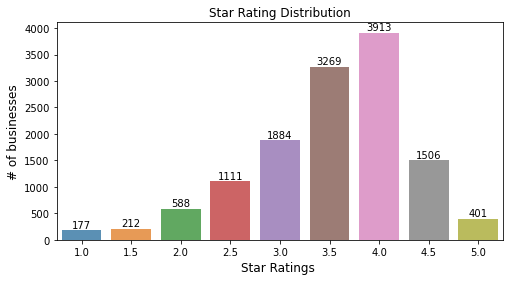

In [187]:
#Get the distribution of the ratings
x=eda_df['rating'].value_counts()
x=x.sort_index()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Star Rating Distribution")
plt.ylabel('# of businesses', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [188]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

In [189]:
eda_df['rating'].value_counts()

4.00    3913
3.50    3269
3.00    1884
4.50    1506
2.50    1111
2.00     588
5.00     401
1.50     212
1.00     177
Name: rating, dtype: int64

<AxesSubplot:xlabel='rating'>

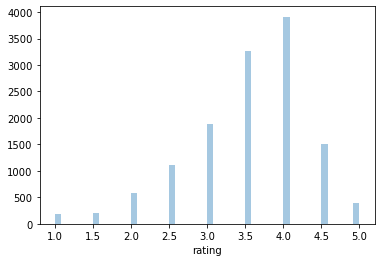

In [190]:
sns.distplot(eda_df.rating, kde=False)

In [191]:
cuisines = pd.DataFrame(eda_df['CUISINE DESCRIPTION'].value_counts())
cuisines.reset_index(inplace=True)
cuisines[0:10]

,index,CUISINE DESCRIPTION
0,American,2775
1,Chinese,1062
2,Pizza,922
3,Coffee/Tea,746
4,Italian,668
5,Japanese,499
6,Bakery Products/Desserts,430
7,Latin American,427
8,Mexican,412
9,Sandwiches,331


There are  82  different types of cuisines in NYC


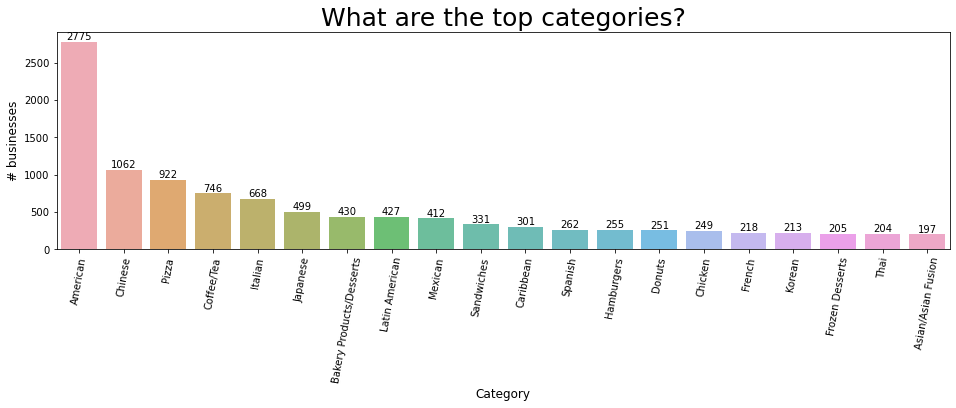

In [192]:
# What are the popular Cuisine categories?
cuisine_cats = eda_df['CUISINE DESCRIPTION']

x = cuisine_cats.value_counts()

print("There are ",len(x)," different types of cuisines in NYC")

#prep for chart
x = x.sort_values(ascending=False)
x = x.iloc[0:20]

#chart
plt.figure(figsize=(16,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)#,color=color[5])
plt.title("What are the top categories?",fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)
plt.ylabel('# businesses', fontsize=12)
plt.xlabel('Category', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [193]:
eda_df.columns

Index(['CAMIS', 'DBA', 'CUISINE DESCRIPTION', 'BORO', 'BUILDING', 'STREET',
       'ZIPCODE', 'PHONE', 'Latitude', 'Longitude', 'Community Board',
       'Council District', 'Census Tract', 'Severe', 'id', 'review_count',
       'rating', 'transactions', 'price', 'Reviews'],
      dtype='object')

In [194]:
# Most reviewed restaurants
eda_df[['CAMIS','id','DBA', 'review_count', 'rating']].sort_values(ascending=False, by="review_count")[0:50]

,CAMIS,id,DBA,review_count,rating
1542,50062888,V7lXZKBDzScDeGB8JmnzSA,KATZS DELICATESSEN (DEKALB MARKET),13458,4.00
1540,40732665,V7lXZKBDzScDeGB8JmnzSA,KATZ'S DELICATESSEN,13458,4.00
9764,50005848,44SY464xDHbvOcjDzRbKkQ,IPPUDO,10219,4.00
769,40402172,WIhm0W9197f_rRtDziq5qQ,LOMBARDI'S,6289,4.00
10880,50017243,UA2M9QFZghe-9th2KwLoWQ,BURGER & LOBSTER,5592,4.00
7140,41612461,ga6sRtE0l85iftw_5-W84Q,DOMINIQUE ANSEL BAKERY,4971,4.00
3284,41172734,U5hCNNyJmb7f3dmC1HTzSQ,JUNIOR'S RESTAURANT,4971,4.00
3282,41172734,U5hCNNyJmb7f3dmC1HTzSQ,JUNIOR'S RESTAURANT,4970,4.00
7138,41612461,ga6sRtE0l85iftw_5-W84Q,DOMINIQUE ANSEL BAKERY,4969,4.00
7312,41627819,xt4sa64WOrpJvZBDPNPNYg,JACOB'S PICKLES,4765,4.00


In [195]:
# Look at all the feautres compared to the 0 class and 1 class

In [196]:
labels_df = eda_df['Severe']
labels_df.shape

(13061,)

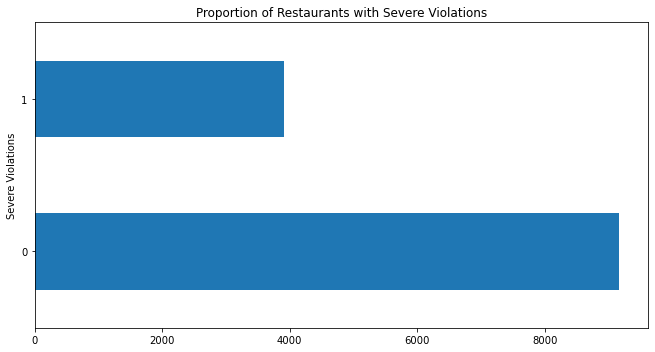

In [199]:
fig, ax = plt.subplots(figsize=(9.2, 5))

n_obs = labels_df.shape

(eda_df['Severe']
    .value_counts()
    .plot.barh(title="Proportion of Restaurants with Severe Violations", ax=ax)
)
ax.set_ylabel("Severe Violations")

fig.tight_layout()

In [200]:
counts = (eda_df[['BORO', 'Severe']]
              .groupby(['BORO', 'Severe'])
              .size()
              .unstack('Severe')
         )
counts

Severe,0,1
BORO,,
0,1,2
Bronx,664,312
Brooklyn,2025,916
Manhattan,4063,1683
Queens,2092,862
Staten Island,313,128


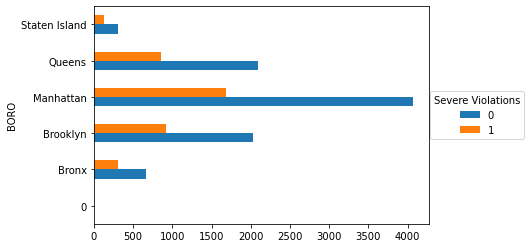

In [201]:
ax = counts.plot.barh()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='Severe Violations'
);

In [202]:
severe_counts = counts.sum(axis='columns')
severe_counts

BORO
0                   3
Bronx             976
Brooklyn         2941
Manhattan        5746
Queens           2954
Staten Island     441
dtype: int64

In [203]:
props = counts.div(severe_counts, axis='index')
props

Severe,0,1
BORO,,
0,0.33,0.67
Bronx,0.68,0.32
Brooklyn,0.69,0.31
Manhattan,0.71,0.29
Queens,0.71,0.29
Staten Island,0.71,0.29


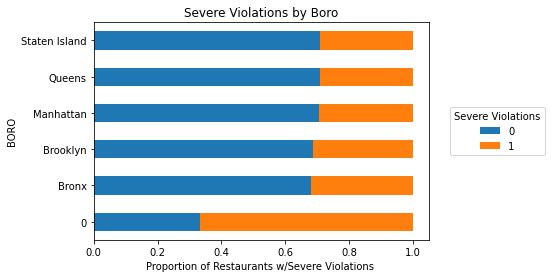

In [204]:
# Prototyping Stack Barh plot
ax = props.plot.barh(stacked=True)
ax.set_title('Severe Violations by Boro')
ax.set_xlabel('Proportion of Restaurants w/Severe Violations ')
ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    title='Severe Violations'
);

In [205]:
def violation_rate_plot(col, target, data, ax=None):
    """Stacked bar chart of severe health and safety violations rate against 
    each feature of the data. 
    
    Args:
        col (string): column name of feature variable
        target (string): column name of target variable
        data (pandas DataFrame): dataframe that contains columns 
            `col` and `target`
        ax (matplotlib axes object, optional): matplotlib axes 
            object to attach plot to
    """
    counts = (eda_df[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)

    ax.legend().remove()

In [206]:
eda_df.columns

Index(['CAMIS', 'DBA', 'CUISINE DESCRIPTION', 'BORO', 'BUILDING', 'STREET',
       'ZIPCODE', 'PHONE', 'Latitude', 'Longitude', 'Community Board',
       'Council District', 'Census Tract', 'Severe', 'id', 'review_count',
       'rating', 'transactions', 'price', 'Reviews'],
      dtype='object')

In [208]:
# Loop through several columns and plot against both severe violations.

cols_to_plot = [
    'rating',
    'transactions',
    'price'
]

fig, ax = plt.subplots(
    len(cols_to_plot), figsize=(10,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    
    violation_rate_plot(
        col, 'Severe', eda_df, ax=ax[idx]
    )
    

ax[0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='Severe Violations'
)
fig.tight_layout()

ValueError: 
$$
^
Expected end of text, found '$'  (at char 0), (line:1, col:1)

ValueError: 
$$
^
Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 720x540 with 3 Axes>

In [209]:
# import street map
# https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

street_map = gpd.read_file('data/Borough_Boundaries/geo_export_392103e7-13e2-43bf-aaf0-7e5c6a24b7b2.shp')


In [210]:
geo_eda = eda_df.copy()

In [211]:
geo_eda.dropna(axis=0, subset=['Latitude','Longitude'], inplace=True)

In [212]:
# Remove the most extreme .1% latitudes, &
# the most extreme .1% longitudes

geo_eda = geo_eda[
 (geo_eda['Latitude'] >= np.percentile(geo_eda['Latitude'], 0.05)) & 
 (geo_eda['Latitude'] < np.percentile(geo_eda['Latitude'], 99.95)) &
 (geo_eda['Longitude'] >= np.percentile(geo_eda['Longitude'], 0.05)) & 
 (geo_eda['Longitude'] <= np.percentile(geo_eda['Longitude'], 99.95))
]

In [213]:
geo_eda = geo_eda[geo_eda['Longitude'] != 0]

In [214]:
geo_eda = geo_eda[geo_eda['Latitude'] != 0]

In [215]:
print(geo_eda['Longitude'].max())
print(geo_eda['Longitude'].min())
print(geo_eda['Latitude'].max())
print(geo_eda['Latitude'].min())

-73.700928057808
-74.241580331187
40.905490121208
40.511011068362


In [216]:
# designate coordinate system
crs = {'init':'epsg:4326'}
# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(geo_eda['Longitude'], geo_eda['Latitude'])]

In [217]:
# create GeoPandas dataframe
geo_df = gpd.GeoDataFrame(geo_eda, crs=crs, geometry = geometry)

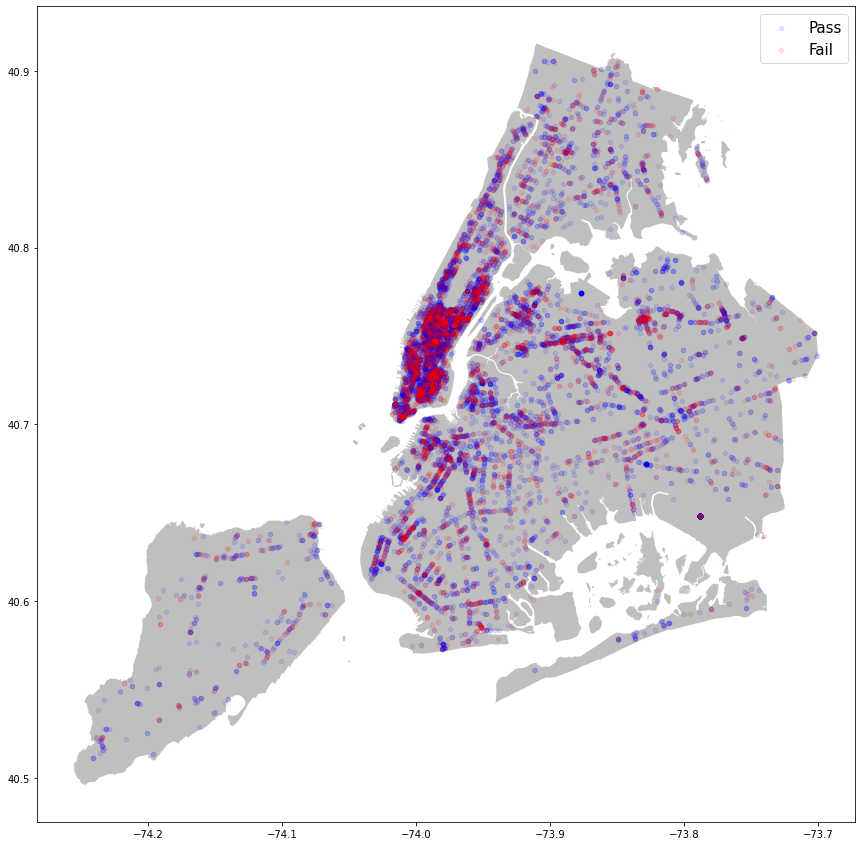

In [218]:
# Plotting map
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=.5,color='gray')
geo_df[geo_df['Severe'] == 0].plot(ax=ax, alpha=.1, markersize=20,color='blue',label='Pass')
geo_df[geo_df['Severe'] == 1].plot(ax=ax, alpha=.1, markersize=20,color='red',label='Fail')
plt.legend(prop={'size':15});

# Preprocessing For Further EDA

### Lets find most frequent words in Negative reviews

Basically, we will find most frequent words in reviews to get an overview of why users gave low ratings. These words could be related to those business attributes or services about which users are most unhappy.



In [226]:
txt_eda = df_4.copy()

In [228]:
passed_df = txt_eda.loc[txt_eda['Severe']==0]
passed_df

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
0,30112340,WENDY'S,Hamburgers,Brooklyn,469,FLATBUSH AVENUE,11225.00,+17182875005,40.66,-73.96,309.00,40.00,32700.00,0,AMxMPBkWi20dn_1BRalahA,wendys-brooklyn-4,Wendy's,https://s3-media0.fl.yelpcdn.com/bphoto/fR70FbX4_WV2-ofhsE89YA/o.jpg,False,https://www.yelp.com/biz/wendys-brooklyn-4?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,55,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'burgers', 'title': 'Burgers'}]",1.50,"{'latitude': 40.662952, 'longitude': -73.961753}",['delivery'],$,"{'address1': '469 Flatbush Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11225', 'country': 'US', 'state': 'NY', 'display_address': ['469 Flatbush Ave', 'Brooklyn, NY 1122...",+17182875005,(718) 287-5005,Forgot my root beer and the burger tasted very weird.If I can give this place no stars I absolutely would. The workers here are in efficient. They do not work the best possible way. They cause th...
1,40356018,RIVIERA CATERERS,American,Brooklyn,2780,STILLWELL AVENUE,11224.00,+17183723031,40.58,-73.98,313.00,47.00,34800.00,0,g8fAhVqBsC-BN6otcn85OA,riviera-caterers-brooklyn,Riviera Caterers,https://s3-media0.fl.yelpcdn.com/bphoto/5qZ27Uarz2kNWxV3KktK1g/o.jpg,False,https://www.yelp.com/biz/riviera-caterers-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,55,"[{'alias': 'catering', 'title': 'Caterers'}]",4.50,"{'latitude': 40.57952, 'longitude': -73.98243}",[],NaN,"{'address1': '2780 Stillwell Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11224', 'country': 'US', 'state': 'NY', 'display_address': ['2780 Stillwell Ave', 'Brooklyn, NY ...",+17183723031,(718) 372-3031,"I had my wedding here a month ago and I would give Riviera 10 stars if I could. It was such a joy and ease to work with Adam, Tommy, and their staff. A true diamond in the rough of Coney Island a..."
2,40356483,WILKEN'S FINE FOOD,Sandwiches,Brooklyn,7114,AVENUE U,11234.00,+17184443838,40.62,-73.91,318.00,46.00,70000.00,0,Pe6MsH2DW0CXjvUtxUpI4A,wilkens-fine-foods-brooklyn-2,Wilkens Fine Foods,https://s3-media0.fl.yelpcdn.com/bphoto/gOyUSHz_oJWiN9Nw0AEpVg/o.jpg,False,https://www.yelp.com/biz/wilkens-fine-foods-brooklyn-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,54,"[{'alias': 'delis', 'title': 'Delis'}]",3.00,"{'latitude': 40.6199, 'longitude': -73.90685}","['pickup', 'delivery']",$$,"{'address1': '7114 Ave U', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11234', 'country': 'US', 'state': 'NY', 'display_address': ['7114 Ave U', 'Brooklyn, NY 11234']}",+17184443838,(718) 444-3838,We've recently discovered this gem on Uber Eats and they have the best sandwiches!!The broccoli rabe fried eggplant mozzarella sandwich was amazing. Having a fresh green veggie paired with a light...
3,40356731,TASTE THE TROPICS ICE CREAM,Frozen Desserts,Brooklyn,1839,NOSTRAND AVENUE,11226.00,+17188560821,40.64,-73.95,317.00,45.00,82800.00,0,Q18r5FKi2qkQhtKZqWR8ww,taste-the-tropics-usa-brooklyn,Taste the Tropics USA,https://s3-media0.fl.yelpcdn.com/bphoto/xW8S_DHdStqZiqjwQ_UUKw/o.jpg,False,https://www.yelp.com/biz/taste-the-tropics-usa-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,49,"[{'alias': 'icecream', 'title': 'Ice Cream & Frozen Yogurt'}]",4.50,"{'latitude': 40.64083, 'longitude': -73.94835}","['pickup', 'delivery']",$,"{'address1': '1839 Nostrand Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '112

In [229]:
failed_df = txt_eda.loc[txt_eda['Severe']==1]
failed_df

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
6,40360076,CARVEL,Frozen Desserts,Brooklyn,203,CHURCH AVENUE,11218.00,+17184389501,40.64,-73.98,312.00,39.00,49600.00,1,Xx-vjaRGaI6DO14VlerPew,carvel-brooklyn-3,Carvel,https://s3-media0.fl.yelpcdn.com/bphoto/GFZ0N9LdAcFYzedIBX9xlA/o.jpg,False,https://www.yelp.com/biz/carvel-brooklyn-3?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,32,"[{'alias': 'icecream', 'title': 'Ice Cream & Frozen Yogurt'}]",3.50,"{'latitude': 40.6434787, 'longitude': -73.9781848}","['pickup', 'delivery']",$,"{'address1': '203 Church Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11218', 'country': 'US', 'state': 'NY', 'display_address': ['203 Church Ave', 'Brooklyn, NY 11218']}",+17184389501,(718) 438-9501,"I love carvel there used to be carvel at Nostrand Avenue and Church Avenue back in the nineties that one closed down, but this location is located in the Kensington section of Brooklyn .there ice ..."
17,40363630,LORENZO & MARIA'S KITCHEN,Continental,Manhattan,1418,THIRD AVENUE,10028.00,+12127941080,40.78,-73.96,108.00,5.00,14000.00,1,ngPB-OKxAk4b-0yBwRuT4g,lorenzo-and-marias-kitchen-new-york,Lorenzo & Marias Kitchen,https://s3-media0.fl.yelpcdn.com/bphoto/o0bPNsOo7GoVHga9ATkPhA/o.jpg,False,https://www.yelp.com/biz/lorenzo-and-marias-kitchen-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,34,"[{'alias': 'food', 'title': 'Food'}]",2.50,"{'latitude': 40.7753, 'longitude': -73.95678}",[],$$,"{'address1': '1418 3rd Ave', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10028', 'country': 'US', 'state': 'NY', 'display_address': ['1418 3rd Ave', 'New York, NY 10028']}",+12127941080,(212) 794-1080,"I have a love-hate relationship with this place. Over time, I came to know which dishes are really worth the highway-robbery-style pricing, and whether my visit -and the potential witnessing of th..."
27,40364362,21 CLUB,American,Manhattan,21,WEST 52 STREET,10019.00,+12125827200,40.76,-73.98,105.00,4.00,10400.00,1,wFjELmsEYh972BG79HwMqA,upstairs-at-21-new-york,Upstairs at 21,https://s3-media0.fl.yelpcdn.com/bphoto/Lq-xykZkT13F8SxYSLLO8A/o.jpg,False,https://www.yelp.com/biz/upstairs-at-21-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,10,"[{'alias': 'newamerican', 'title': 'American (New)'}]",4.50,"{'latitude': 40.76037, 'longitude': -73.97741}",[],$$$$,"{'address1': '21 W 52nd St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10019', 'country': 'US', 'state': 'NY', 'display_address': ['21 W 52nd St', 'New York, NY 10019']}",+12125827200,(212) 582-7200,"Sophisticated atmosphere, prompt courteous staff, and food that is an out of this world experience. I was in Manhattan for work and the three of us made a Friday night reservation before we went ..."
28,40364362,21 CLUB,American,Manhattan,21,WEST 52 STREET,10019.00,+12125827200,40.76,-73.98,105.00,4.00,10400.00,1,RSGqAGFmgfoVssOBfkldXA,21-club-new-york,21 Club,https://s3-media0.fl.yelpcdn.com/bphoto/ZVUicCEhf-vI_9eZG3UPHw/o.jpg,True,https://www.yelp.com/biz/21-club-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,630,"[{'alias': 'tradamerican', 'title': 'American (Traditional)'}, {'alias': 'venues', 'title': 'Venues & Event Spaces'}]",3.50,"{'latitude': 40.76037, 'longitude': -73.97741}",[],$$$$,"{'address1': '21 W 52nd St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10019', 'country': 'US', 'state': 'NY', 'display_addre

In [230]:
passed_corpus = passed_df['Reviews'].to_list()
passed_corpus[:5]

['Forgot my root beer and the burger tasted very weird.If I can give this place no stars I absolutely would. The workers here are in efficient. \xa0They do not work the best possible way. They cause the wait to be longer than it needs to be. If you can avoid this Wendy\'s definitely do so. It\'ll make your lives happier. There is no need for this place to be the way that it is. It\'s fast food. Not slow food.The service I just received from this establishment was incredibly terrible. My entire order was incorrect and nothing was done to right the situation, I am allergic to mayonnaise and my sandwich (the wrong one of course) was smothered in it. I just don\'t understand how businesses can get away with this kind of the treatment towards the clientele that keep them running and often thriving during these harsh times..I Just Ordered From This Place - First Time Ever Doing Any Kind Of Take Out With them And First Time In A Long Ass Time Even Getting Anything Outta There Honestly.., I Me

In [231]:
failed_corpus = failed_df['Reviews'].to_list()
failed_corpus[:5]

["I love carvel there used to be carvel at Nostrand Avenue and Church Avenue back in the nineties that one closed down, but this location is located in the Kensington section of Brooklyn .there ice cream is great, I love coming here to this location I'll definitely mind coming back in heartbeat. Staff members are cool too! \xa0(their delivery here as well I'm not sure if it's from Grubhub, uber eats, door dash, postmates, etc )- call in double check P.S. something about Carvel ice cream that does it, no offense Baskin Robbins .....Lol !!!!( all dough I could go to the shop and stop supermarket and get a carvel ice cream cake box I prefer to come here, instead ).Very convenient by the MTA transportation:Subway:F, G-Trains. Church avenue. Train station.Bus:B35 ,B67,B103.Had the vanilla ice cream it tasted off ... Now I'm home at 3am in the morning with food poisoning. Be wary..Cousin & I went to polish off our dinner with some ice cream. Best sundaes we ever had. The amount of fudge was 

In [253]:
# Tokenizing the corpus of review text from restaurants that have severly failed their inspection
failed_tokens = word_tokenize(','.join(failed_corpus))


In [247]:
# Tokenizing the corpus of review text from restaurants that have not severly  their inspection
passed_tokens = word_tokenize(','.join(passed_corpus))

In [240]:
# Importing English stop words
stopwords_list = stopwords.words('english')
# Add punctuation marks to the stopwords_list
stopwords_list.extend(string.punctuation)
additional_punc = ['“','”','...',"''",'’','``']
stopwords_list.extend(additional_punc)

In [254]:
# Removing stopwords from failed_corpus
stopped_failed_tokens = [w.lower() for w in failed_tokens if w.lower() not in stopwords_list]
stopped_failed_tokens[:10]

['love',
 'carvel',
 'used',
 'carvel',
 'nostrand',
 'avenue',
 'church',
 'avenue',
 'back',
 'nineties']

In [248]:
# Removing stopwords from passed_corpus
stopped_passed_tokens = [w.lower() for w in passed_tokens if w.lower() not in stopwords_list]
stopped_passed_tokens[:10]

['forgot',
 'root',
 'beer',
 'burger',
 'tasted',
 'weird.if',
 'give',
 'place',
 'stars',
 'absolutely']

In [242]:
# Creating FreqDist from stopped_failed_tokens
freq_failed = FreqDist(stopped_failed_tokens)
freq_failed.most_common(15)

[("n't", 27371),
 ('food', 26695),
 ("'s", 24690),
 ('..', 22707),
 ('good', 20802),
 ('place', 18501),
 ('like', 13681),
 ('great', 12793),
 ('one', 11126),
 ('order', 11084),
 ('chicken', 10993),
 ('would', 10692),
 ('time', 10682),
 ('get', 10465),
 ('service', 10413),
 ('also', 10159),
 ('really', 9961),
 ('ordered', 9904),
 ('back', 9263),
 ('go', 8240),
 ('got', 8195),
 ("'ve", 7830),
 ('restaurant', 7626),
 ('delicious', 7513),
 ('came', 7087)]

In [250]:
# Creating FreqDist from stopped_passed_tokens
freq_passed = FreqDist(stopped_passed_tokens)
freq_passed.most_common(15)

[("n't", 61902),
 ("'s", 57877),
 ('..', 52341),
 ('food', 51417),
 ('good', 43223),
 ('place', 41092),
 ('like', 31262),
 ('great', 29465),
 ('one', 26900),
 ('get', 25008),
 ('order', 24921),
 ('time', 24885),
 ('would', 24063),
 ('service', 23419),
 ('also', 22430)]

In [245]:
# Functionizing wordcloud generator
def wordcloud_generator(tokens, collocations=False, background_color='black', 
                       colormap='Reds', display=True):

    
    # Initalize a WordCloud
    wordcloud = WordCloud(collocations=collocations, 
                          background_color=background_color, 
                          colormap=colormap, 
                          width=500, height=300)

    # Generate wordcloud from tokens
    wordcloud.generate(','.join(tokens))

    # Plot with matplotlib
    if display:
        plt.figure(figsize = (12, 15), facecolor = None) 
        plt.imshow(wordcloud) 
        plt.axis('off');
        
    return wordcloud
    

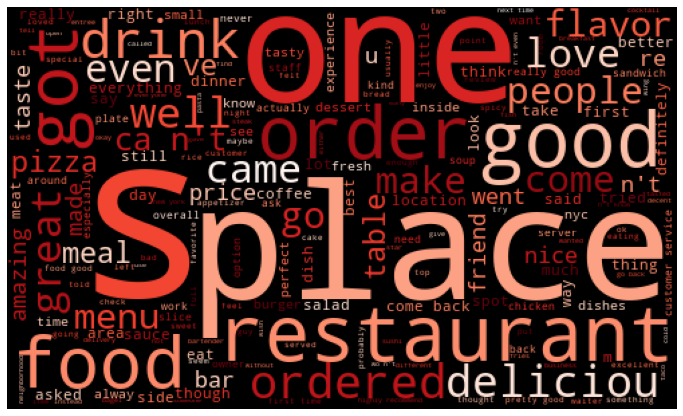

In [246]:
# Generating a WordCloud for reviews from restaurants that have failed their inspection
failed_cloud = wordcloud_generator(stopped_failed_tokens, collocations=True)

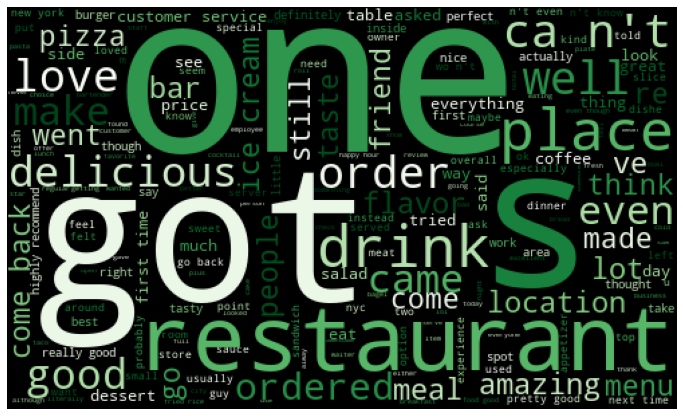

In [251]:
# Generate a WordCloud from reviews of restaurants that have not severely failed an inspection
passsed_cloud = wordcloud_generator(stopped_passed_tokens, colormap='Greens',
                                     collocations=True)

### Bigrams

In [255]:
# Bigrams from reviews of failed inspections
bigram_measures = nltk.collocations.BigramAssocMeasures()
review_finder = nltk.BigramCollocationFinder.from_words(stopped_failed_tokens)
reviews_scored = review_finder.score_ngrams(bigram_measures.raw_freq)

In [256]:
# df from the Bigrams
pd.DataFrame(reviews_scored, columns=["Word","Freq"]).head(10)

,Word,Freq
0,"(ca, n't)",0.00
1,"(come, back)",0.00
2,"(really, good)",0.00
3,"(customer, service)",0.00
4,"(pretty, good)",0.00
5,"(first, time)",0.00
6,"(could, n't)",0.00
7,"(would, n't)",0.00
8,"(food, good)",0.00
9,"(wo, n't)",0.00


In [257]:
# Bigrams from reviews of restaurants passed their inspections
bigram_measures = nltk.collocations.BigramAssocMeasures()
review_finder = nltk.BigramCollocationFinder.from_words(stopped_passed_tokens)
reviews_scored = review_finder.score_ngrams(bigram_measures.raw_freq)

In [258]:
# df from the Bigrams
pd.DataFrame(reviews_scored, columns=["Word","Freq"]).head(10)

,Word,Freq
0,"(ca, n't)",0.00
1,"(come, back)",0.00
2,"(ice, cream)",0.00
3,"(customer, service)",0.00
4,"(first, time)",0.00
5,"(really, good)",0.00
6,"(could, n't)",0.00
7,"(highly, recommend)",0.00
8,"(n't, even)",0.00
9,"(pretty, good)",0.00


In [324]:
# FREQ DIST PLOT FOR MOST FREQ WORDS IN PASSED AND FAILED RESTAURANTS

In [259]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Rob/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [262]:
sid = SentimentIntensityAnalyzer()

In [263]:
a =  'This is an excellent restaurant!'

In [264]:
sid.polarity_scores(a)

{'neg': 0.0, 'neu': 0.501, 'pos': 0.499, 'compound': 0.6114}

In [290]:
df_5['price'].value_counts()

$$      5952
$       3945
$$$      817
$$$$     251
Name: price, dtype: int64

In [291]:
# Mapping prices to ordinal categories
price_dict={'$$$$': 4, '$$$': 3, '$$': 2, '$': 1}

df_5['prices'] = df_5['price'].map(price_dict)

In [295]:
# Imputing a zeros for NAN values
df_5['prices'].fillna(0,inplace=True)

In [297]:
transactions = df_5['transactions']

In [298]:
# Use ast module to convert string objects into list
transactions = transactions.apply(lambda x: ast.literal_eval(x))

In [299]:
# Change list into dicts
dcts = transactions.apply(lambda x: {c: 1 for c in x})

# Create new dataframe based on the list of dictionaries.
ohe_df = pd.DataFrame(dcts.tolist()).fillna(0)


In [270]:
ohe_df

,delivery,pickup,restaurant_reservation
0,1.00,0.00,0.00
1,0.00,0.00,0.00
2,1.00,1.00,0.00
3,1.00,1.00,0.00
4,1.00,1.00,0.00
...,...,...,...
13056,0.00,0.00,0.00
13057,1.00,0.00,0.00
13058,0.00,0.00,1.00
13059,1.00,1.00,0.00


In [300]:
# Concatenate dummy variales with the full dataset
df_5 = pd.concat([df_5,ohe_df],axis=1)
df_5.head()

,DBA,CUISINE DESCRIPTION,BORO,ZIPCODE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,review_count,rating,transactions,price,Reviews,prices,delivery,pickup,restaurant_reservation
0,WENDY'S,Hamburgers,Brooklyn,11225.00,40.66,-73.96,309.00,40.00,32700.00,0.00,55.00,1.50,['delivery'],$,Forgot my root beer and the burger tasted very weird.If I can give this place no stars I absolutely would. The workers here are in efficient. They do not work the best possible way. They cause th...,1.00,1.00,0.00,0.00
1,RIVIERA CATERERS,American,Brooklyn,11224.00,40.58,-73.98,313.00,47.00,34800.00,0.00,55.00,4.50,[],NaN,"I had my wedding here a month ago and I would give Riviera 10 stars if I could. It was such a joy and ease to work with Adam, Tommy, and their staff. A true diamond in the rough of Coney Island a...",0.00,0.00,0.00,0.00
2,WILKEN'S FINE FOOD,Sandwiches,Brooklyn,11234.00,40.62,-73.91,318.00,46.00,70000.00,0.00,54.00,3.00,"['pickup', 'delivery']",$$,We've recently discovered this gem on Uber Eats and they have the best sandwiches!!The broccoli rabe fried eggplant mozzarella sandwich was amazing. Having a fresh green veggie paired with a light...,2.00,1.00,1.00,0.00
3,TASTE THE TROPICS ICE CREAM,Frozen Desserts,Brooklyn,11226.00,40.64,-73.95,317.00,45.00,82800.00,0.00,49.00,4.50,"['pickup', 'delivery']",$,We've ordered from these folks a number of times on Grubhub and have always been extremely satisfied. We've never been to the actual store but I have called over there a few times with some questi...,1.00,1.00,1.00,0.00
4,TASTE THE TROPICS ICE CREAM,Frozen Desserts,Brooklyn,11226.00,40.64,-73.95,317.00,45.00,82800.00,0.00,49.00,4.50,"['delivery', 'pickup']",$,We've ordered from these folks a number of times on Grubhub and have always been extremely satisfied. We've never been to the actual store but I have called over there a few times with some questi...,1.00,1.00,1.00,0.00


In [302]:
df_5.drop(columns=['price','transactions'],inplace=True)

# Preprocessing For Modeling

In [340]:
df_4.columns

Index(['CAMIS', 'DBA', 'CUISINE DESCRIPTION', 'BORO', 'BUILDING', 'STREET',
       'ZIPCODE', 'PHONE', 'Latitude', 'Longitude', 'Community Board',
       'Council District', 'Census Tract', 'Severe', 'id', 'alias', 'name',
       'image_url', 'is_closed', 'url', 'review_count', 'categories', 'rating',
       'coordinates', 'transactions', 'price', 'location', 'phone',
       'display_phone', 'Reviews'],
      dtype='object')

In [341]:
# Dropping unneccessary columns
model_df = df_4.drop(columns=['CAMIS', 'DBA', 'CUISINE DESCRIPTION', 'BORO',
                               'BUILDING', 'STREET','ZIPCODE', 'PHONE',
                               'Latitude', 'Longitude', 'Community Board',
                               'Council District', 'Census Tract', 
                               'id', 'alias', 'name','image_url', 'is_closed',
                               'url', 'review_count', 'categories', 'rating',
                               'coordinates', 'transactions', 'price',
                               'location', 'phone','display_phone'])

In [342]:
model_df.head(3)

,Severe,Reviews
0,0,Forgot my root beer and the burger tasted very weird.If I can give this place no stars I absolutely would. The workers here are in efficient. They do not work the best possible way. They cause th...
1,0,"I had my wedding here a month ago and I would give Riviera 10 stars if I could. It was such a joy and ease to work with Adam, Tommy, and their staff. A true diamond in the rough of Coney Island a..."
2,0,We've recently discovered this gem on Uber Eats and they have the best sandwiches!!The broccoli rabe fried eggplant mozzarella sandwich was amazing. Having a fresh green veggie paired with a light...


In [343]:
model_df['Reviews'].isna().sum()

0

In [345]:
# Checking for duplicates
model_df.duplicated(keep='first').sum()

1521

In [346]:
# Dropping duplicates
model_df.drop_duplicates(keep='first', inplace=True)

# Confirming duplicates have been dropped

model_df.duplicated(keep='first').sum()

0

In [351]:
# Checking Class Balance
model_df['Severe'].value_counts()

0    7935
1    3605
Name: Severe, dtype: int64

In [352]:
# Make X and y
y = model_df['Severe'].copy()
X = model_df['Reviews'].copy()

In [353]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42)


In [354]:
# Using NLTK's Regular Expressions Tokenizer from nltk.tokenize
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
tokenizer

RegexpTokenizer(pattern='[a-zA-Z0-9]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)

In [357]:
# Creating a Count Vectorizer the RE tokenizer's .tokenize method
vectorizer = CountVectorizer(lowercase=True, tokenizer=tokenizer.tokenize,
                            stop_words=stopwords_list)

In [358]:
# Vectorizing the data and saving X_train_bow and X_test_bow
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)
X_train_bow

<8078x65608 sparse matrix of type '<class 'numpy.int64'>'
	with 2621611 stored elements in Compressed Sparse Row format>

# Models

## Bag-of-Words Model



In [362]:
# Create and fit a Decision Tree Classifier
dt = DecisionTreeClassifier(class_weight='balanced', max_depth=6)
dt.fit(X_train_bow,y_train)


DecisionTreeClassifier(class_weight='balanced', max_depth=6)

In [ ]:
### Function to produce the model's coefficients

def eval_clf(model, X_test_tf,y_test,cmap='Reds',
                            normalize='true',classes=['Unvaccinated', 'Vaccinated'],figsize=(10,4),
                            X_train = None, y_train = None,):
    """Evaluates a scikit-learn binary classification model.

    Args:
        model ([type]): [description]
        X_test_tf ([type]): [description]
        y_test ([type]): [description]
        cmap (str, optional): [description]. Defaults to 'Reds'.
        normalize (str, optional): [description]. Defaults to 'true'.
        classes ([type], optional): [description]. Defaults to None.
        figsize (tuple, optional): [description]. Defaults to (8,4).
        X_train ([type], optional): [description]. Defaults to None.
        y_train ([type], optional): [description]. Defaults to None.
    """
    
    
    y_hat_test = model.predict(X_test_tf)
    print(metrics.classification_report(y_test, y_hat_test,target_names=classes))
    

    fig,ax = plt.subplots(ncols=2,figsize=figsize)
    plt.grid(False)
    plot_confusion_matrix(model, X_test_tf,y_test,cmap=cmap, 
                                  normalize=normalize,display_labels=classes,
                                 ax=ax[0])
    for a in ax:
        a.grid(False)   
        
    curve = metrics.plot_roc_curve(model,X_test_tf,y_test,ax=ax[1])
    curve.ax_.grid()
    curve.ax_.plot([0,1],[0,1],ls=':')
    fig.tight_layout()
    plt.show()
    
    ## Add comparing Scores if X_train and y_train provided.
    if (X_train is not None) & (y_train is not None):
        print(f"Training Score = {model.score(X_train,y_train):.2f}")
        print(f"Test Score = {model.score(X_test_tf,y_test):.2f}")

In [ ]:
## Creating baseline classifier model

base = DummyClassifier(strategy='stratified', random_state = 42)

base.fit(X_train_df, y_train)

eval_clf(base,X_test_tf,y_test,X_train=X_train_df,y_train=y_train)

## TF-IDF Models


##  Deep NLP Models


# Interpreting Results

In [ ]:
# get the names of the features
feature_names = np.array(vec.get_feature_names())

def get_top_features(features, model, level, limit, bottom=False):
    """ Get the top (most likely to see violations) and bottom (least
        likely to see violations) features for a given model.
        
        :param features: an array of the feature names
        :param model: a fitted linear regression model
        :param level: 0, 1, 2 for *, **, *** violation levels
        :param limit: how many features to return
        :param worst: if we want the bottom features rather than the top 
    """
    # sort order for the coefficients
    sorted_coeffs = np.argsort(model.coef_[i])
    
    if bottom:
        # get the features at the end of the sorted list
        return features[sorted_coeffs[-1 * limit:]]
    else:
        # get the features at the beginning of the sorted list
        return features[sorted_coeffs[:limit]]
    
# get the features that indicate we are most and least likely to see violations
worst_feature_sets = [get_top_features(feature_names, ols, i, 100) for i in range(3)]
best_feature_sets = [get_top_features(feature_names, ols, i, 100, bottom=True) for i in range(3)]

# reduce the independent feature sets to just the ones
# that we see in common across the per-level models (*, **, ***)
worst = reduce(np.intersect1d, best_feature_sets)
best = reduce(np.intersect1d, worst_feature_sets)

# display as a pretty table
html_fmt = "<table><th>More Violations</th><th>Fewer Violations</th><tbody>{}</tbody></table>"
table_rows = ["<tr><td>{}</td><td>{}</td></tr>".format(w, b) for w, b in zip(worst, best)]
table_body = "\n".join(table_rows)
display.HTML(html_fmt.format(table_body))

# Conclusions

## Best Model Results

## Takeaways and Recommended Actions

##  Next Steps and Future Work